In [1]:
from metabolinks import align, read_aligned_spectra, read_spectra_from_xcel
from metabolinks.similarity import mz_similarity

### Similarity analysis without CHT, CFN and SB samples.

All further changes to code will first be implemented on the original similarity_analysis. This is an altered version of said original.

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described and try tosay what is happening in each block of code.

## Similarity analysis
aligned_all_neg = negative dataset alignment 2-1 (Original) / aligned_neg - binary matrix equivalent

aligned_all_pos = positive dataset alignment 2-1 (Original) / aligned_pos - binary matrix equivalent

aligned_all_neg2 = negative dataset alignment 3-3 / aligned_neg2 - binary matrix equivalent

aligned_all_pos2 = positive dataset alignment 3-3 / aligned_pos2 - binary matrix equivalent

#### Read aligned data, using peaks that appear in at least 2 samples

In [2]:
from metabolinks import AlignedSpectra
aligned_all_pos_f = read_aligned_spectra('aligned_1ppm_min2_1ppm_positive.csv', labels=True, sep=',')
aligned_all_neg_f = read_aligned_spectra('aligned_1ppm_min2_1ppm_negative.csv', labels=True, sep=',')

de_neg = aligned_all_neg_f.data
de_neg = de_neg[["14","15","16","29","30","31","8","9","10","23","24","25","38","39","40","17","18","19","26","27","28","20","21","22","35","36","37","32","33","34"]]
aligned_all_neg = AlignedSpectra(de_neg, labels=["CAN","CAN","CAN","CS","CS","CS","LAB","LAB","LAB","PN","PN","PN","REG","REG","REG","RIP","RIP","RIP","RL","RL","RL","ROT","ROT","ROT","RU","RU","RU","TRI","TRI","TRI"])

de_pos = aligned_all_pos_f.data
de_pos = de_pos[["14","15","16","29","30","31","8","9","10","23","24","25","38","39","40","17","18","19","26","27","28","20","21","22","35","36","37","32","33","34"]]
aligned_all_pos = AlignedSpectra(de_pos, labels=["CAN","CAN","CAN","CS","CS","CS","LAB","LAB","LAB","PN","PN","PN","REG","REG","REG","RIP","RIP","RIP","RL","RL","RL","ROT","ROT","ROT","RU","RU","RU","TRI","TRI","TRI"])

#print('------ positive mode aligned --------------')
#print(aligned_all_pos.info())
#print('------ negative mode aligned --------------')
#print(aligned_all_neg.info())

#### Compute m/z similarities

In [3]:
sim_pos = mz_similarity(aligned_all_pos)
sim_neg = mz_similarity(aligned_all_neg)

In [4]:
print(sim_pos)


Sample similarity, counts of common peaks
     14   15   16   29   30   31    8    9   10    23  ...   28   20   21  \
14  330  277  253  202  200  195  207  214  207   152  ...  211  133  132   
15  277  379  302  233  232  224  227  231  223   179  ...  239  146  143   
16  253  302  355  222  222  218  212  212  208   164  ...  229  148  146   
29  202  233  222  667  514  526  230  233  235   308  ...  388  162  148   
30  200  232  222  514  612  471  236  236  235   284  ...  376  162  149   
31  195  224  218  526  471  624  232  237  239   294  ...  367  166  150   
8   207  227  212  230  236  232  489  399  369   182  ...  233  148  152   
9   214  231  212  233  236  237  399  501  381   184  ...  241  147  147   
10  207  223  208  235  235  239  369  381  471   181  ...  244  152  155   
23  152  179  164  308  284  294  182  184  181  1487  ...  334  127  118   
24  151  176  162  308  286  297  187  190  188  1246  ...  330  125  117   
25  146  174  159  296  269  286 

In [5]:
print(sim_neg)


Sample similarity, counts of common peaks
     14   15   16   29   30   31    8    9   10   23  ...   28   20   21   22  \
14  442  286  345  186  183  170  168  179  179   34  ...  104  156  141  146   
15  286  319  222  121  118  108  144  157  155   25  ...   86  134  121  125   
16  345  222  378  174  171  159  168  181  177   34  ...   95  108  100  109   
29  186  121  174  674  637  588  143  151  150   88  ...  416  106   97  106   
30  183  118  171  637  677  591  142  150  149   88  ...  416  108   99  108   
31  170  108  159  588  591  628  128  135  135   87  ...  409  103   95  103   
8   168  144  168  143  142  128  370  331  339  118  ...  168  111  107  115   
9   179  157  181  151  150  135  331  402  371  111  ...  163  121  115  123   
10  179  155  177  150  149  135  339  371  410  120  ...  171  114  110  118   
23   34   25   34   88   88   87  118  111  120  350  ...  150   36   39   39   
24   46   33   45   95   95   94  127  121  129  314  ...  156   4

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns
import pandas as pd

In [7]:
dfpos = pd.DataFrame(sim_pos.sample_similarity_jaccard,
                     columns=sim_pos.sample_names,
                     index=sim_pos.sample_names)

dfneg = pd.DataFrame(sim_neg.sample_similarity_jaccard,
                     columns=sim_neg.sample_names,
                     index=sim_neg.sample_names)

Sample similarity, positive mode


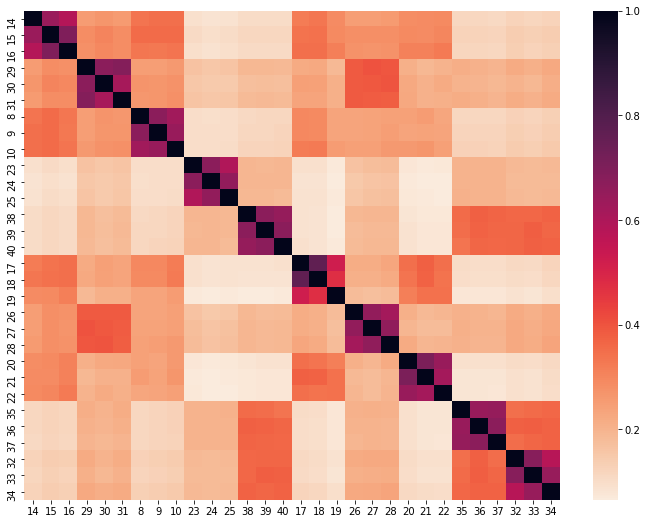

In [8]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, positive mode')
hm = sns.heatmap(dfpos, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Sample similarity, negative mode


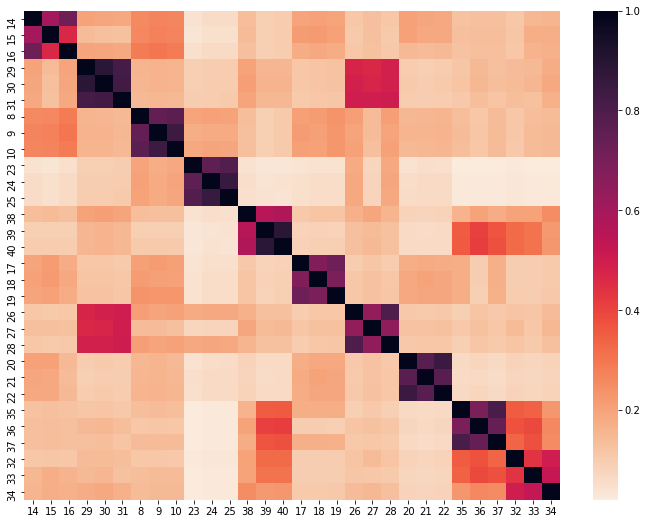

In [9]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, negative mode')
hm = sns.heatmap(dfneg, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [10]:
dfpos = pd.DataFrame(sim_pos.label_similarity_jaccard,
                     columns=sim_pos.unique_labels,
                     index=sim_pos.unique_labels)

dfneg = pd.DataFrame(sim_neg.label_similarity_jaccard,
                     columns=sim_neg.unique_labels,
                     index=sim_neg.unique_labels)

Label similarity, positive mode


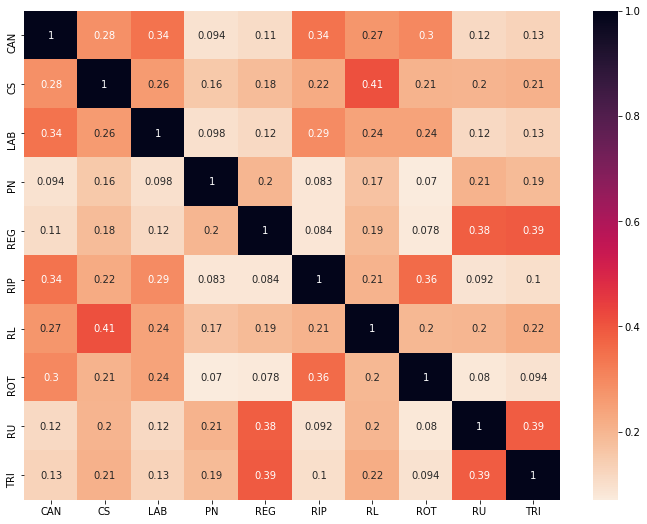

In [11]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, positive mode')
hm = sns.heatmap(dfpos, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Label similarity, negative mode


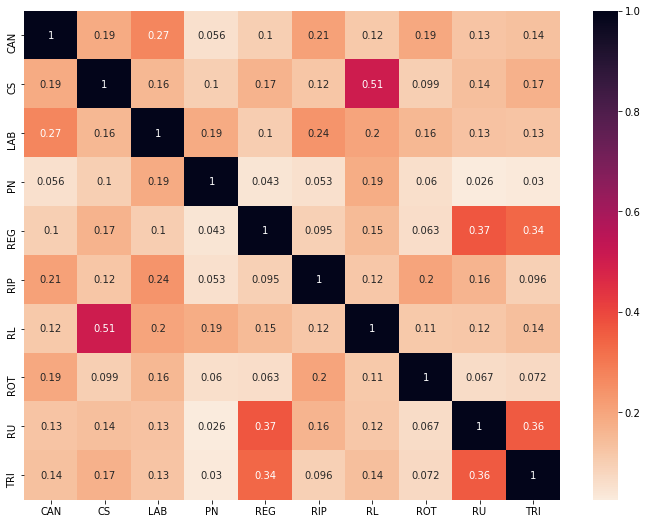

In [12]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, negative mode')
hm = sns.heatmap(dfneg, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Doing... Experiments with scipy functions...

In [13]:
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier

In [14]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    df = df.copy()
    df[df.notnull()] = 1
    df[df.isnull()] = 0
    return df
aligned_01 = df_to_bool(aligned_all_neg.data)
# confirm it is 0's and 1's
#aligned_01

In [15]:
jdist = dist.pdist(aligned_01.T, metric='jaccard')
print(dist.squareform(jdist))
print('------------------------------------')
sim = mz_similarity(aligned_all_neg)
jsim = sim.sample_similarity_jaccard
jdist = 1 - jsim
print(jdist)

[[0.         0.39789474 0.27368421 0.8        0.80448718 0.81111111
  0.73913043 0.73082707 0.73402675 0.95514512 0.94041451 0.94132653
  0.86278814 0.90507365 0.89764419 0.80106101 0.79511533 0.80289093
  0.88624052 0.86568987 0.88817204 0.79337748 0.80763984 0.80915033
  0.87579329 0.86910491 0.86825818 0.88685345 0.84623773 0.84205021]
 [0.39789474 0.         0.53263158 0.86123853 0.86560364 0.87127533
  0.73577982 0.72163121 0.72996516 0.96118012 0.95015106 0.95103858
  0.85588972 0.90441839 0.89624329 0.7834891  0.77990431 0.79510703
  0.89364303 0.86797753 0.89575758 0.79510703 0.80793651 0.81146305
  0.86828774 0.86515642 0.86457311 0.88206388 0.82537688 0.82577566]
 [0.27368421 0.53263158 0.         0.80182232 0.80656109 0.81227863
  0.71034483 0.69782972 0.71031097 0.95100865 0.93653032 0.93758669
  0.86581097 0.90737564 0.89957447 0.82187938 0.81438849 0.82033426
  0.88554913 0.86928105 0.89142857 0.85385656 0.85915493 0.85230352
  0.87464115 0.86863544 0.86778399 0.8862069  

[[0.         0.39789474 0.27368421 0.8        0.80448718 0.81111111
  0.73913043 0.73082707 0.73402675 0.95514512 0.94041451 0.94132653
  0.86278814 0.90507365 0.89764419 0.80106101 0.79511533 0.80289093
  0.88624052 0.86568987 0.88817204 0.79337748 0.80763984 0.80915033
  0.87579329 0.86910491 0.86825818 0.88685345 0.84623773 0.84205021]
 [0.39789474 0.         0.53263158 0.86123853 0.86560364 0.87127533
  0.73577982 0.72163121 0.72996516 0.96118012 0.95015106 0.95103858
  0.85588972 0.90441839 0.89624329 0.7834891  0.77990431 0.79510703
  0.89364303 0.86797753 0.89575758 0.79510703 0.80793651 0.81146305
  0.86828774 0.86515642 0.86457311 0.88206388 0.82537688 0.82577566]
 [0.27368421 0.53263158 0.         0.80182232 0.80656109 0.81227863
  0.71034483 0.69782972 0.71031097 0.95100865 0.93653032 0.93758669
  0.86581097 0.90737564 0.89957447 0.82187938 0.81438849 0.82033426
  0.88554913 0.86928105 0.89142857 0.85385656 0.85915493 0.85230352
  0.87464115 0.86863544 0.86778399 0.8862069  

## Wrapping up in a function...

In [16]:
def clustermap_peak_list(aligned):
    aligned_01 = aligned.data.copy()
    aligned_01[aligned_01.notnull()] = 1
    aligned_01[aligned_01.isnull()] = 0
    
    ulabels = aligned.unique_labels()
    n = len(ulabels)
    
    p = sns.color_palette() + sns.color_palette("Set1", n_colors=n-10, desat=.5)
    sample_to_labels = pd.Series(aligned.labels, index=aligned.sample_names)
    label_colors = pd.Series(p, index=ulabels)
    sample_colors = sample_to_labels.map(label_colors)
    
    g = sns.clustermap(aligned_01, metric="jaccard", figsize=(15, 20), 
                       row_cluster=False,
                       col_colors=sample_colors,
                       yticklabels=False)
    # fix bug in seaborn, error in clustermap if cbar == False
    ax=g.cax; aax=ax.clear(); aax = ax.axis('off'); 

    # draw legend
    lpatches = [mpatches.Patch(color=c, label=lbl) for (lbl, c) in label_colors.iteritems()]
    leg = plt.legend(handles=lpatches, fontsize=20)
    return g
    

Sample HC, NEGATIVE mode


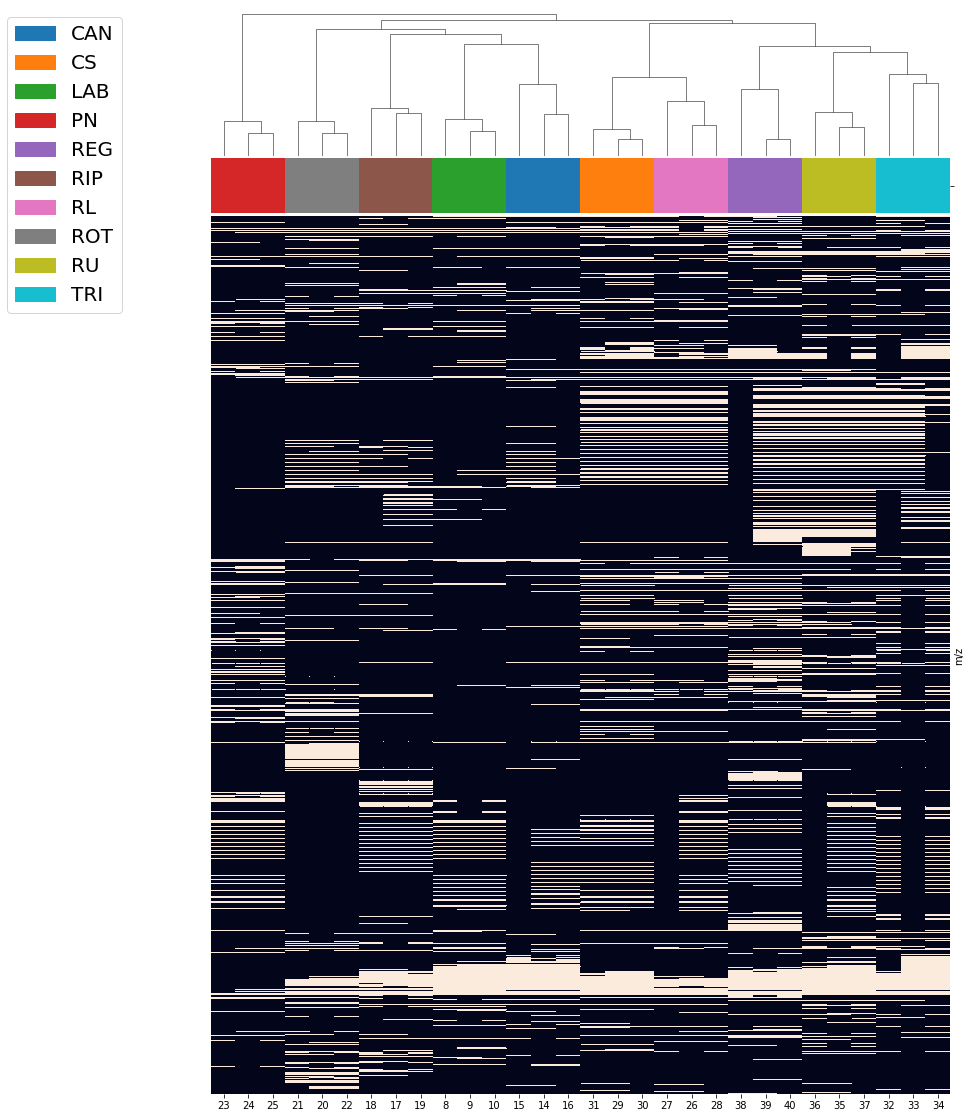

In [17]:
print('Sample HC, NEGATIVE mode')
g = clustermap_peak_list(aligned_all_neg)
g.savefig('sampleHC_negative.pdf')


Sample HC, POSITIVE mode


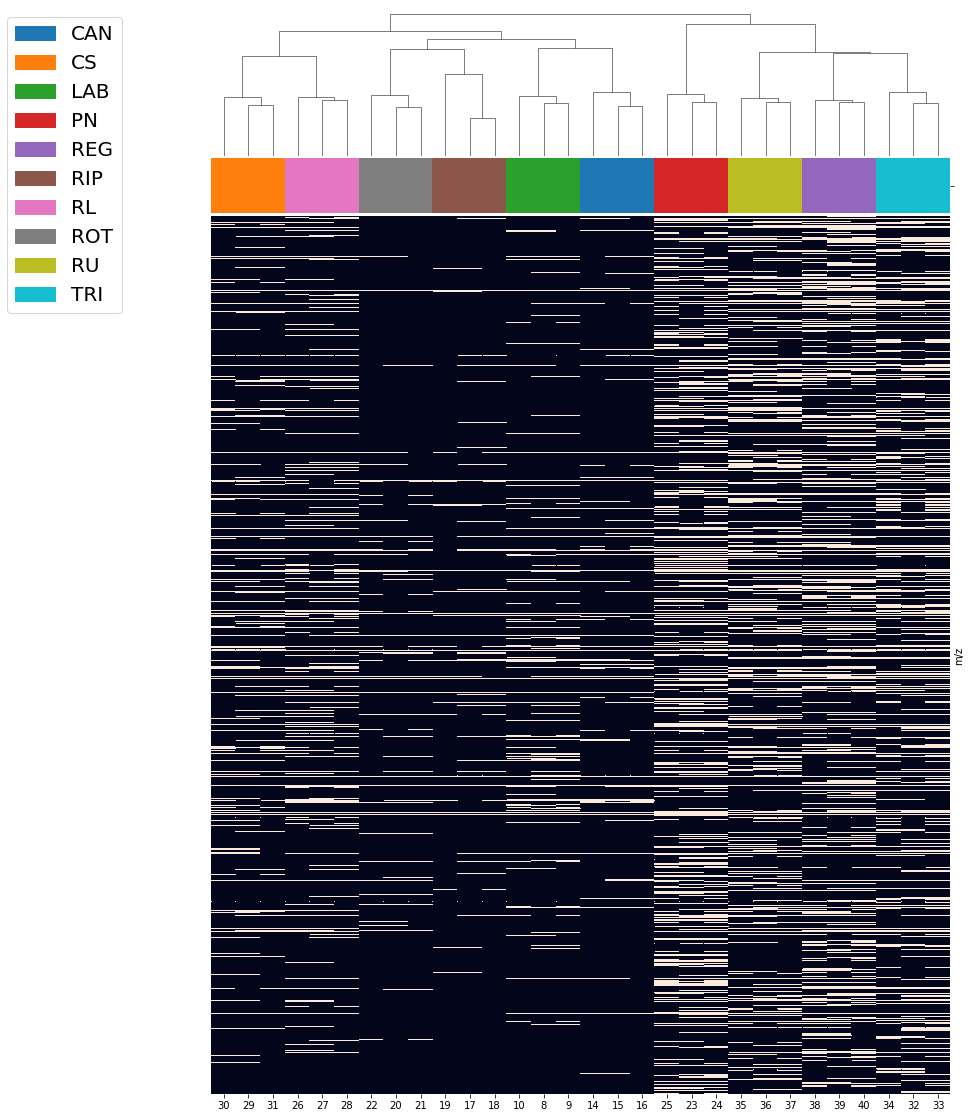

In [18]:
print('Sample HC, POSITIVE mode')
g = clustermap_peak_list(aligned_all_pos)
g.savefig('sampleHC_positive.pdf')

Cultivar dendogram, Jaccard distance, NEGATIVE MODE


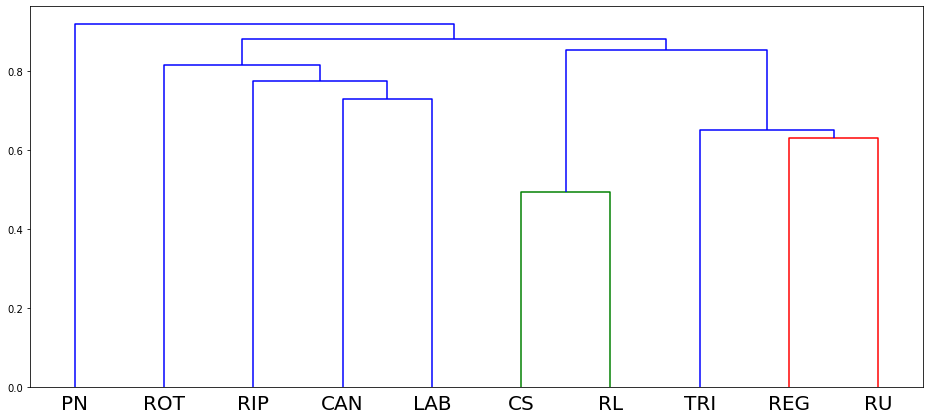

In [19]:
print('Cultivar dendogram, Jaccard distance, NEGATIVE MODE')
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard)
Z = hier.linkage(jdist, method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z, labels=sim_neg.unique_labels,
                     leaf_font_size=20,
                     above_threshold_color='b')
fig.savefig('dendo_cultivars_jaccard_negative.pdf')

In [20]:
print(hier.cophenet(Z,jdist)[0])

0.9209358373807722


Cultivar dendogram, Jaccard distance, POSITIVE MODE


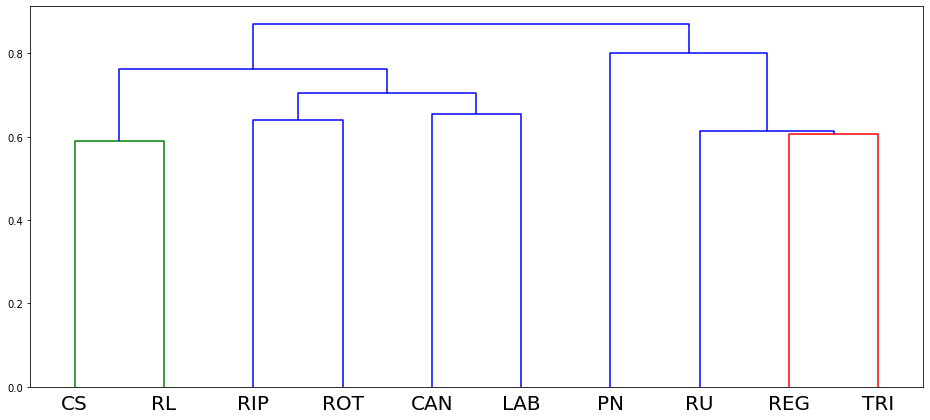

In [21]:
print('Cultivar dendogram, Jaccard distance, POSITIVE MODE')
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard)
Z = hier.linkage(jdist, method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z, labels=sim_pos.unique_labels,
                     leaf_font_size=20,
                     above_threshold_color='b')
fig.savefig('dendo_cultivars_jaccard_positive.pdf')

In [22]:
print(hier.cophenet(Z,jdist)[0])

0.9177776331679081


### Other Binary Similarity Analysis Methods

In [23]:
aligned_neg = df_to_bool(aligned_all_neg.data)
aligned_pos = df_to_bool(aligned_all_pos.data)

Creating the colours label for all dendrograms (negative and positive have the same labels):

In [24]:
label_colors = {}
colours = cm.get_cmap('nipy_spectral', 10)
col_lbl = colours(range(10))
for i in range(len(col_lbl)):
    label_colors[aligned_all_neg.labels[3*i]] = col_lbl[i]

Cultivar dendogram, Binary methods, NEGATIVE MODE


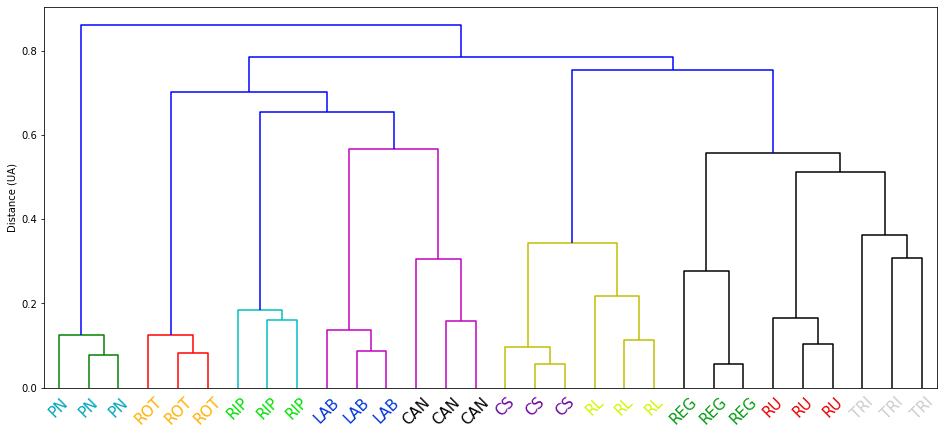

In [25]:
#Apply one of the following:
#dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule
#kulsinski, rusellrao

print('Cultivar dendogram, Binary methods, NEGATIVE MODE')
Zdice_neg = hier.linkage(aligned_neg.T, metric = 'dice', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=aligned_all_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Cultivar dendogram, Binary methods, POSITIVE MODE


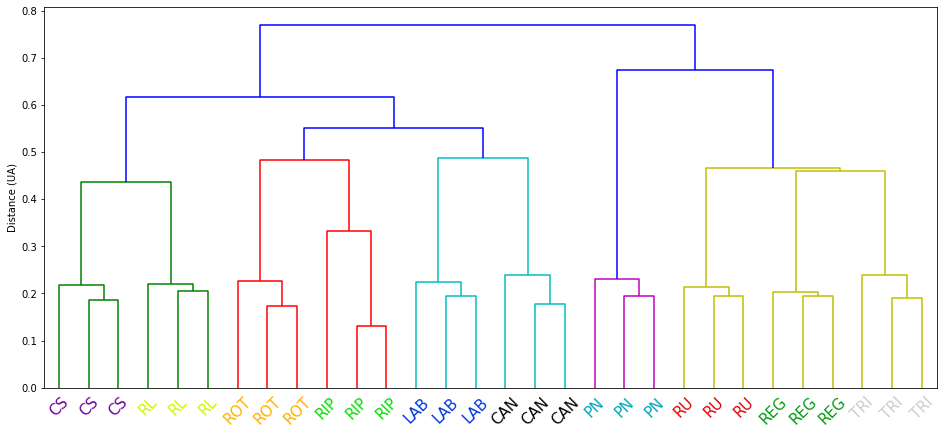

In [26]:
print('Cultivar dendogram, Binary methods, POSITIVE MODE')
Zdice_pos = hier.linkage(aligned_pos.T, metric = 'dice', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_pos, labels=aligned_all_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

### Non-binary Similarity Analysis

All samples need to have missing value imputation (removing features is optional) with the function NaN_Imputation of scaling.py (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where 3 different processing methods were applied in different combinations:

##### Normalization by a references feature (Norm_feat from scaling.py) - N;
##### Glog transformation/ log2 transformation (glog from scaling.py) - G;
##### Pareto Scaling (ParetoScal from scaling.py) - P.
Three combinations were used and compared: 1) Only Pareto Scaling (P), Normalization by a reference feature and Pareto Scaling (NP) and Normalization by a reference feature, glog transformation and Pareto Scaling (NGP).

In [27]:
import scaling as sca
import numpy as np

#### Negative Mode - Original peak alignment

3 types of processing:

Euc_P_neg - Missing Value Imputation and Pareto Scaling.

Euc_NP_neg - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

Euc_NGP_neg - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [28]:
#Euc_P_neg
Imputated_neg = sca.NaN_Imputation(aligned_all_neg, 0.00001)
Euc_P_neg = sca.ParetoScal(Imputated_neg)

Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation and Pareto Scaling


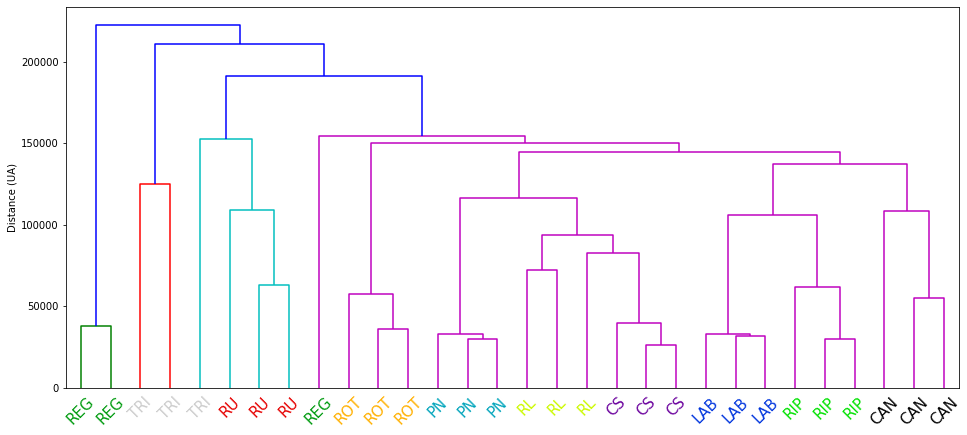

In [29]:
#Measure Euclidean distances
dist_euc_P_neg = dist.pdist(Euc_P_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation and Pareto Scaling')
Z_euc_P_neg = hier.linkage(dist_euc_P_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_P_neg, labels=Euc_P_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [30]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_euc_P_neg,dist_euc_P_neg)[0]) #method average seems to lead to higher coefficients

0.9195827620011211


In [31]:
#Euc_NP_neg
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

(554.26202, 0.0005200000000513683)


In [32]:
Norm_neg = sca.Norm_Feat(Imputated_neg, 554.26202)
Euc_NP_neg = sca.ParetoScal(Norm_neg)

Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation, Normalized and Pareto Scaling


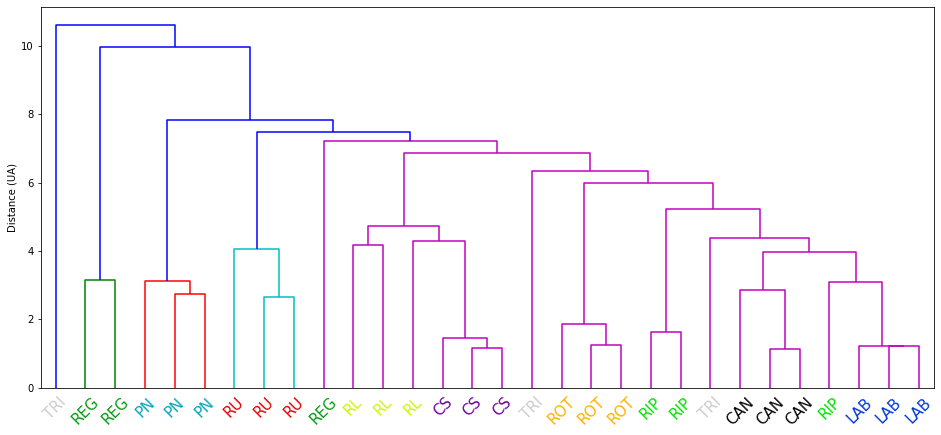

In [33]:
#Measure Euclidean distances
dist_euc_NP_neg = dist.pdist(Euc_NP_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation, Normalized and Pareto Scaling')
Z_euc_NP_neg = hier.linkage(dist_euc_NP_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NP_neg, labels=Euc_NP_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [34]:
print(hier.cophenet(Z_euc_NP_neg,dist_euc_NP_neg)[0]) 

0.8947920259447498


In [35]:
#Euc_NGP_neg
glog_neg = sca.glog(Norm_neg)
Euc_NGP_neg = sca.ParetoScal(glog_neg)

Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation, Normalized, Transformed and Pareto Scaling


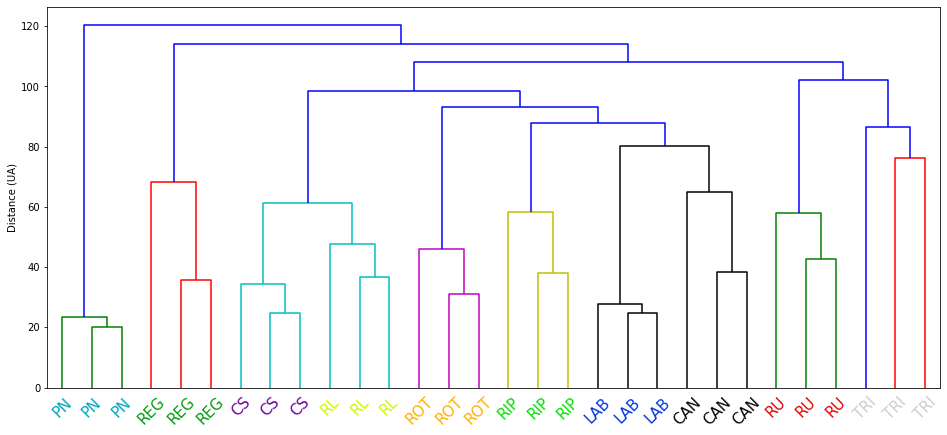

In [36]:
#Measure Euclidean distances
dist_euc_NGP_neg = dist.pdist(Euc_NGP_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation, Normalized, Transformed and Pareto Scaling')
Z_euc_NGP_neg = hier.linkage(dist_euc_NGP_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NGP_neg, labels=Euc_NGP_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [37]:
print(hier.cophenet(Z_euc_NGP_neg,dist_euc_NGP_neg)[0]) 

0.8508510958099832


#### Positive Mode - Original peak alignment

3 types of processing:

Euc_P_pos - Missing Value Imputation and Pareto Scaling.

Euc_NP_pos - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

Euc_NGP_pos - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [38]:
#Euc_P_pos
Imputated_pos = sca.NaN_Imputation(aligned_all_pos, 0.00001)
Euc_P_pos = sca.ParetoScal(Imputated_pos)

Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation and Pareto Scaling


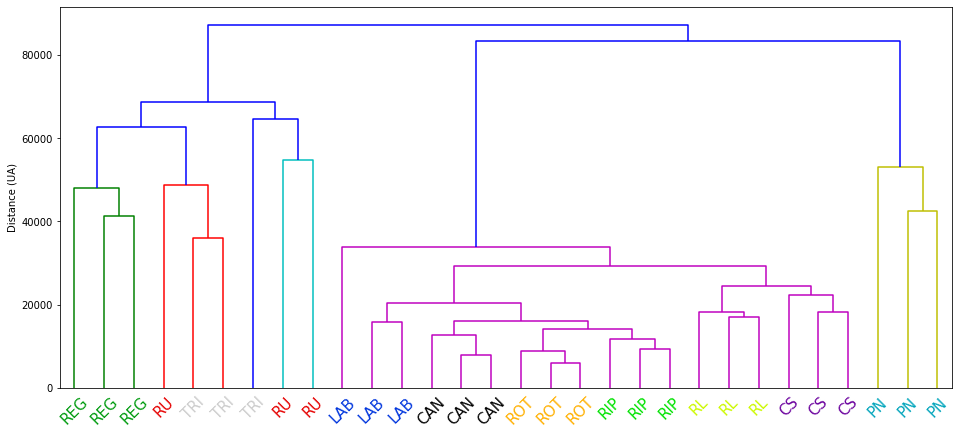

In [39]:
#Measure Euclidean distances
dist_euc_P_pos = dist.pdist(Euc_P_pos.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation and Pareto Scaling')
Z_euc_P_pos = hier.linkage(dist_euc_P_pos, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_P_pos, labels=Euc_P_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [40]:
print(hier.cophenet(Z_euc_P_pos,dist_euc_P_pos)[0])

0.9761517084498552


In [41]:
#Euc_NP_pos
#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.2771)
print(RefEst_Pos)

(556.2765712820513, 0.0005287179486686)


In [42]:
Norm_pos = sca.Norm_Feat(Imputated_pos, 556.2765712820513)
Euc_NP_pos = sca.ParetoScal(Norm_pos)

Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation, Normalized and Pareto Scaling


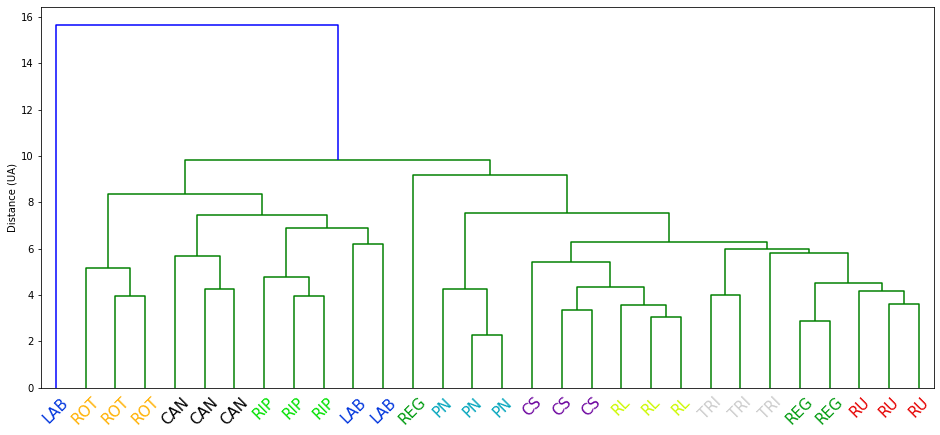

In [43]:
#Measure Euclidean distances
dist_euc_NP_pos = dist.pdist(Euc_NP_pos.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation, Normalized and Pareto Scaling')
Z_euc_NP_pos = hier.linkage(dist_euc_NP_pos, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NP_pos, labels=Euc_NP_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [44]:
print(hier.cophenet(Z_euc_NP_pos,dist_euc_NP_pos)[0])

0.8569581728873317


In [45]:
#Euc_NGP_pos
glog_pos = sca.glog(Norm_pos)
Euc_NGP_pos = sca.ParetoScal(glog_pos)

Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation, Normalized, Transformed and Pareto Scaling


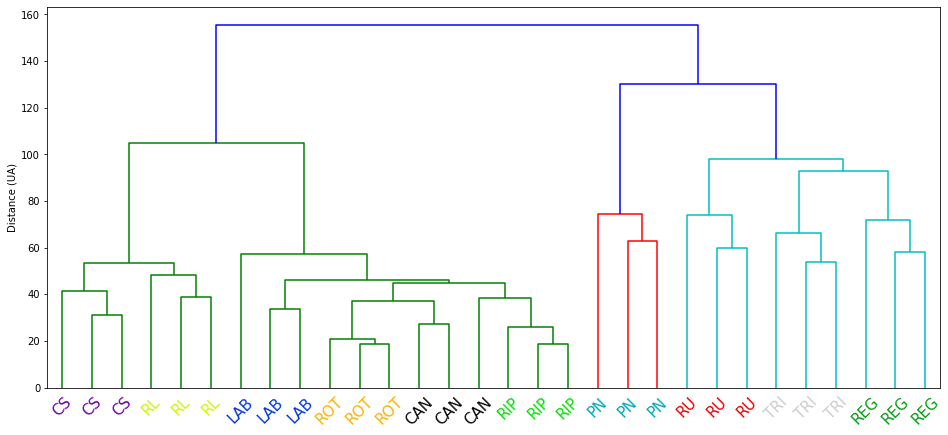

In [46]:
#Measure Euclidean distances
dist_euc_NGP_pos = dist.pdist(Euc_NGP_pos.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation, Normalized, Transformed and Pareto Scaling')
Z_euc_NGP_pos = hier.linkage(dist_euc_NGP_pos, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NGP_pos, labels=Euc_NGP_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [47]:
print(hier.cophenet(Z_euc_NGP_pos,dist_euc_NGP_pos)[0])

0.8432410750486585


## 2nd Peak Alignment - 3-3

#### Negative Mode - Peak alignment (requires a feature to be present in all samples of at least one variety)

Same procedure as before:

3 types of processing:

Euc_P_neg2 (in script, 3_3 in figures) - Missing Value Imputation and Pareto Scaling.

Euc_NP_neg2 (in script, 3_3 in figures) - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

Euc_NGP_neg2 (in script, 3_3 in figures) - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [48]:
aligned_all_pos2_f = read_aligned_spectra('aligned_1ppm_min3-3_1ppm_positive.csv', labels=True, sep=',')
aligned_all_neg2_f = read_aligned_spectra('aligned_1ppm_min3-3_1ppm_negative.csv', labels=True, sep=',')

de_neg2 = aligned_all_neg2_f.data
de_neg2 = de_neg2[["14","15","16","29","30","31","8","9","10","23","24","25","38","39","40","17","18","19","26","27","28","20","21","22","35","36","37","32","33","34"]]
aligned_all_neg2 = AlignedSpectra(de_neg2, labels=["CAN","CAN","CAN","CS","CS","CS","LAB","LAB","LAB","PN","PN","PN","REG","REG","REG","RIP","RIP","RIP","RL","RL","RL","ROT","ROT","ROT","RU","RU","RU","TRI","TRI","TRI"])

de_pos2 = aligned_all_pos2_f.data
de_pos2 = de_pos2[["14","15","16","29","30","31","8","9","10","23","24","25","38","39","40","17","18","19","26","27","28","20","21","22","35","36","37","32","33","34"]]
aligned_all_pos2 = AlignedSpectra(de_pos2, labels=["CAN","CAN","CAN","CS","CS","CS","LAB","LAB","LAB","PN","PN","PN","REG","REG","REG","RIP","RIP","RIP","RL","RL","RL","ROT","ROT","ROT","RU","RU","RU","TRI","TRI","TRI"])

In [49]:
#Euc_P_neg2
Imputated_neg2 = sca.NaN_Imputation(aligned_all_neg2, 0.00001)
Euc_P_neg2 = sca.ParetoScal(Imputated_neg2)

Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation and Pareto Scaling


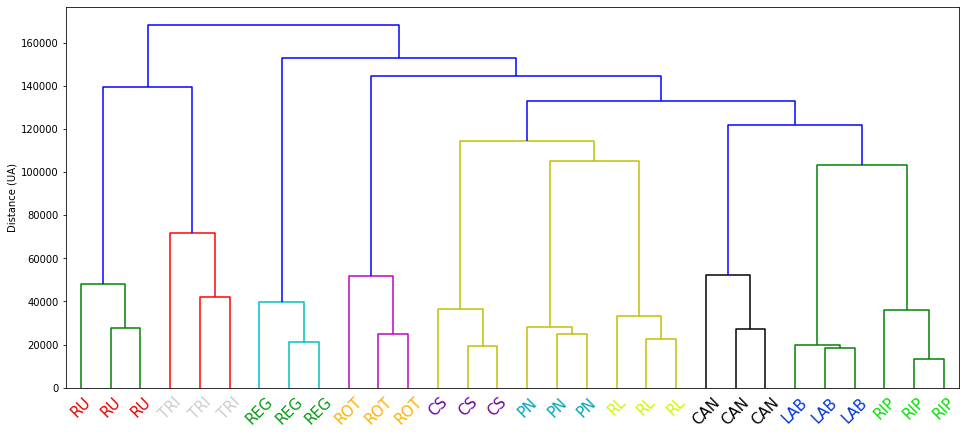

In [50]:
#Measure Euclidean distances
import scipy.spatial.distance as dist
dist_euc_P_neg2 = dist.pdist(Euc_P_neg2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation and Pareto Scaling')
Z_euc_P_neg2 = hier.linkage(dist_euc_P_neg2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_P_neg2, labels=Euc_P_neg2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [51]:
print(hier.cophenet(Z_euc_P_neg2,dist_euc_P_neg2)[0]) 

0.8346922779809163


In [52]:
#Euc_NP_neg2
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_neg2, 554.2615)
print(RefEst_Pos) #Same result as previous alignment.
Norm_neg2 = sca.Norm_Feat(Imputated_neg2, 554.26202)
Euc_NP_neg2 = sca.ParetoScal(Norm_neg2)

(554.26202, 0.0005200000000513683)


Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized and Pareto Scaling


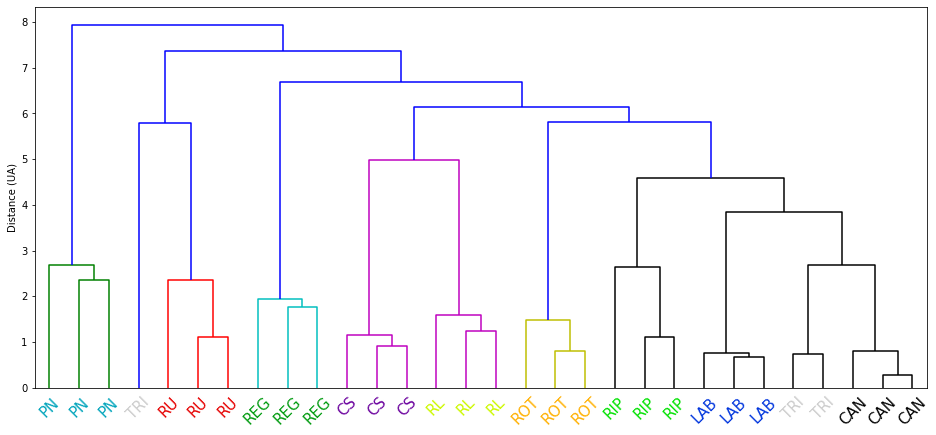

In [53]:
#Measure Euclidean distances
dist_euc_NP_neg2 = dist.pdist(Euc_NP_neg2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized and Pareto Scaling')
Z_euc_NP_neg2 = hier.linkage(dist_euc_NP_neg2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NP_neg2, labels=Euc_NP_neg2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [54]:
print(hier.cophenet(Z_euc_NP_neg2,dist_euc_NP_neg2)[0])

0.8829687860341574


In [55]:
#Euc_NGP_neg2
glog_neg2 = sca.glog(Norm_neg2)
Euc_NGP_neg2 = sca.ParetoScal(glog_neg2)

Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized, Transformed and Pareto Scaling


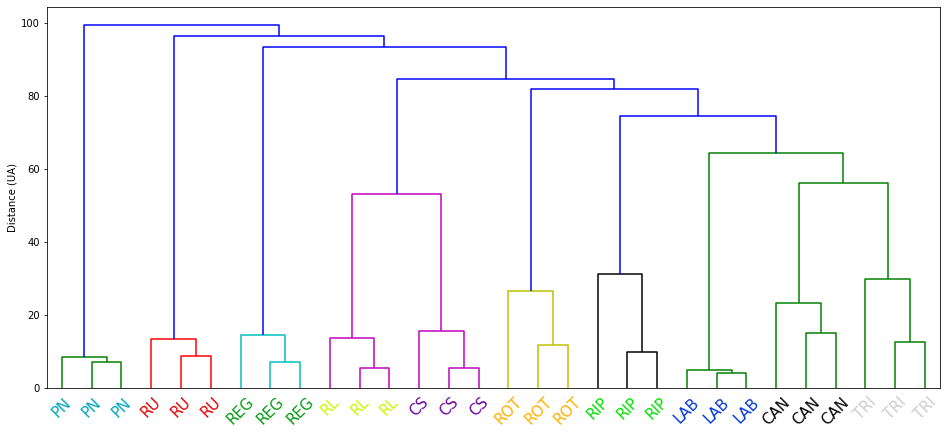

In [56]:
#Measure Euclidean distances
dist_euc_NGP_neg2 = dist.pdist(Euc_NGP_neg2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized, Transformed and Pareto Scaling')
Z_euc_NGP_neg2 = hier.linkage(dist_euc_NGP_neg2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NGP_neg2, labels=Euc_NGP_neg2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [57]:
print(hier.cophenet(Z_euc_NGP_neg2,dist_euc_NGP_neg2)[0]) #method average seems to lead to higher coefficients

0.9229796348841679


#### Positive Mode - Peak alignment (requires a feature to be present in at least all samples of a variety)

Same procedure as before:

3 types of processing:

Euc_P_pos2 (in script, 3_3 in figures) - Missing Value Imputation and Pareto Scaling.

Euc_NP_pos2 (in script, 3_3 in figures) - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

Euc_NGP_pos2 (in script, 3_3 in figures) - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling

In [58]:
#Euc_P_pos2
Imputated_pos2 = sca.NaN_Imputation(aligned_all_pos2, 0.00001)
Euc_P_pos2 = sca.ParetoScal(Imputated_pos2)

Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation and Pareto Scaling


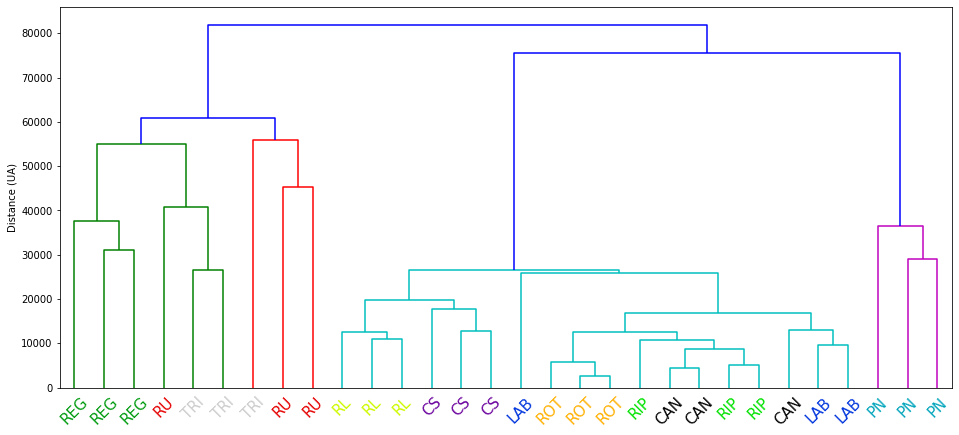

In [59]:
#Measure Euclidean distances
dist_euc_P_pos2 = dist.pdist(Euc_P_pos2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation and Pareto Scaling')
Z_euc_P_pos2 = hier.linkage(dist_euc_P_pos2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_P_pos2, labels=Euc_P_pos2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [60]:
print(hier.cophenet(Z_euc_P_pos2,dist_euc_P_pos2)[0])

0.9737785566392584


In [61]:
#Euc_NP_pos2
#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.2771)
print(RefEst_Pos) #Same result as previous alignment.
Norm_pos2 = sca.Norm_Feat(Imputated_pos2, 556.2765712820513)
Euc_NP_pos2 = sca.ParetoScal(Norm_pos2)

(556.2765712820513, 0.0005287179486686)


Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized and Pareto Scaling


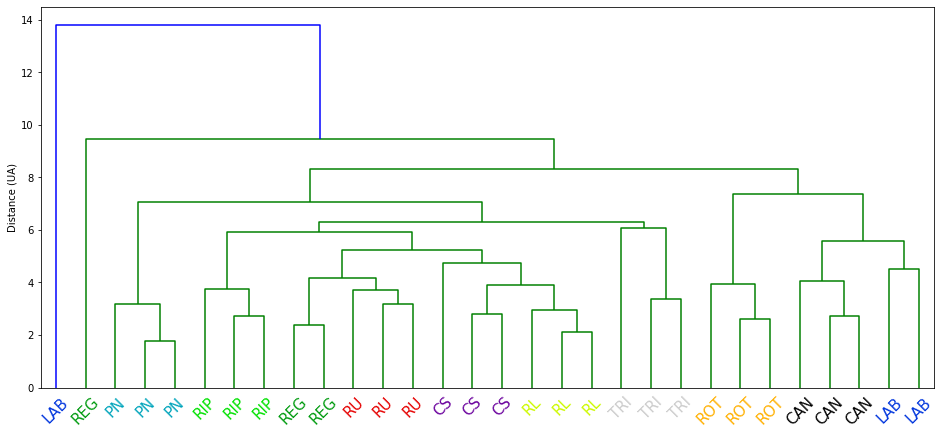

In [62]:
#Measure Euclidean distances
dist_euc_NP_pos2 = dist.pdist(Euc_NP_pos2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized and Pareto Scaling')
Z_euc_NP_pos2 = hier.linkage(dist_euc_NP_pos2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NP_pos2, labels=Euc_NP_pos2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [63]:
print(hier.cophenet(Z_euc_NP_pos2,dist_euc_NP_pos2)[0])

0.8778201042767924


In [64]:
#Euc_NGP_pos
glog_pos2 = sca.glog(Norm_pos2)
Euc_NGP_pos2 = sca.ParetoScal(glog_pos2)

Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized, Transformed and Pareto Scaling


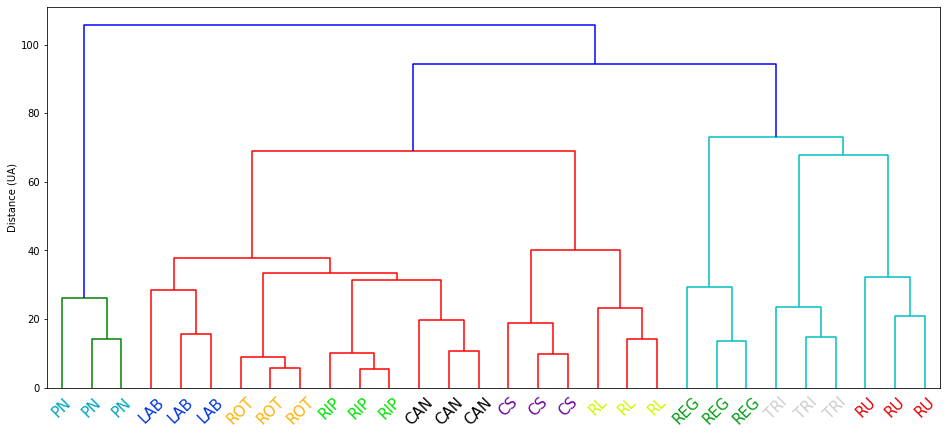

In [65]:
#Measure Euclidean distances
dist_euc_NGP_pos2 = dist.pdist(Euc_NGP_pos2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized, Transformed and Pareto Scaling')
Z_euc_NGP_pos2 = hier.linkage(dist_euc_NGP_pos2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NGP_pos2, labels=Euc_NGP_pos2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [66]:
print(hier.cophenet(Z_euc_NGP_pos2,dist_euc_NGP_pos2)[0])

0.9046927227156321


### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

In [67]:
import numpy as np
import scipy.stats as stats
import multianalysis as ma

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

In [68]:
euclidean = (Z_euc_P_neg, Z_euc_NP_neg, Z_euc_NGP_neg, Z_euc_P_pos, Z_euc_NP_pos, Z_euc_NGP_pos,
            Z_euc_P_neg2, Z_euc_NP_neg2, Z_euc_NGP_neg2, Z_euc_P_pos2, Z_euc_NP_pos2, Z_euc_NGP_pos2)
dist_euclidean = (dist_euc_P_neg, dist_euc_NP_neg, dist_euc_NGP_neg, dist_euc_P_pos, dist_euc_NP_pos, dist_euc_NGP_pos,
                 dist_euc_P_neg2, dist_euc_NP_neg2, dist_euc_NGP_neg2, dist_euc_P_pos2, dist_euc_NP_pos2, dist_euc_NGP_pos2)

K_euc = []
S_euc = []
Coph_euc = []

for i in range(len(euclidean)):
    K_euc.append(ma.mergerank(euclidean[i])) #Mergerank
    S_euc.append(K_euc[i][K_euc[i]!=0]) #Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_euc.append(hier.cophenet(euclidean[i], dist_euclidean[i])) #Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [69]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.kendalltau(S_euc[0],S_euc[1])[0], '\t', stats.kendalltau(S_euc[0],S_euc[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.kendalltau(S_euc[0],S_euc[2])[0], '\t', stats.kendalltau(S_euc[0],S_euc[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.49770594785189787 	 2.841436241688467e-86
Euc_P_neg-Euc_NGP_neg	 0.4057982056831566 	 4.601042303188374e-56


According to the explanation given in the R package dendextend

In [70]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.spearmanr(S_euc[0],S_euc[1])[0], '\t', stats.spearmanr(S_euc[0],S_euc[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.spearmanr(S_euc[0],S_euc[2])[0], '\t', stats.spearmanr(S_euc[0],S_euc[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.6240662692699944 	 4.333842792048118e-95
Euc_P_neg-Euc_NGP_neg	 0.46485036761576476 	 7.515824325455241e-48


#### Cophenetic Correlation Coefficient

In [71]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [72]:
print('Pair of samples      \tPearson Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[1][1])[0], '\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[1][1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[2][1])[0], '\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.7616472733366593 	 1.2899791846294668e-83
Euc_P_neg-Euc_NGP_neg	 0.6931326898284689 	 1.506492284868182e-63


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

In [73]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')

In [74]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg.T, metric = binary[i]))) #Cophenetic

In [75]:
#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_pos.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_pos.T, metric = binary[i]))) #Cophenetic

In [76]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
S = []
S.extend(S_euc)
S.extend(S_neg)
S.extend(S_pos)
#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
Coph = []
Coph.extend(Coph_euc)
Coph.extend(Coph_neg)
Coph.extend(Coph_pos)

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [77]:
#Column names and row names for the dataframes
colnames = ['euc_P_neg2_1', 'euc_NP_neg2_1', 'euc_NGP_neg2_1', 'euc_P_pos2_1', 'euc_NP_pos2_1', 'euc_NGP_pos2_1','euc_P_neg3_3',
            'euc_NP_neg3_3', 'euc_NGP_neg3_3', 'euc_P_pos3_3', 'euc_NP_pos3_3', 'euc_NGP_pos3_3','dice_neg2_1', 'hamming_neg2_1',
            'jaccard_neg2_1', 'rogerstanimoto_neg2_1', 'sokalmichener_neg2_1', 'sokalsneath_neg2_1','yule_neg2_1', 
            'kulsinski_neg2_1', 'russellrao_neg2_1','dice_pos2_1', 'hamming_pos2_1', 'jaccard_pos2_1', 'rogerstanimoto_pos2_1', 
            'sokalmichener_pos2_1', 'sokalsneath_pos2_1', 'yule_pos2_1', 'kulsinski_pos2_1', 'russellrao_pos2_1']

In [78]:
df_K = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #K - Kendall (Baker)
df_S = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #S - Spearman (Baker)
df_C = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #C - Cophenetic Correlation
df_K_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of K method
df_S_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of S method
df_C_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of C method

In [79]:
#Calculation of correlation coefficient for each method
for i in range(len(S)):
    for j in range(len(S)):
        df_K.iloc[i,j] = stats.kendalltau(S[i],S[j])[0] #Correlation coefficient
        df_S.iloc[i,j] = stats.spearmanr(S[i],S[j])[0] #Correlation coefficient
        df_C.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[0] #Correlation coefficient
        df_K_p.iloc[i,j] = stats.kendalltau(S[i],S[j])[1] #p-value
        df_S_p.iloc[i,j] = stats.spearmanr(S[i],S[j])[1] #p-value
        df_C_p.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[1] #p-value
        
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,len(S)))* np.nan, columns = colnames, index=[''])
lineV = pd.concat([line.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,12:]], axis = 1)
df_KI = pd.concat([df_K.iloc[:12], line, df_K.iloc[12:]])
df_KI = pd.concat([df_KI.iloc[:,:12], lineV.T, df_KI.iloc[:,12:]], axis = 1)
df_SI = pd.concat([df_S.iloc[:12], line, df_S.iloc[12:]])
df_SI = pd.concat([df_SI.iloc[:,:12], lineV.T, df_SI.iloc[:,12:]], axis = 1)
df_CI = pd.concat([df_C.iloc[:12], line, df_C.iloc[12:]])
df_CI = pd.concat([df_CI.iloc[:,:12], lineV.T, df_CI.iloc[:,12:]], axis = 1)

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


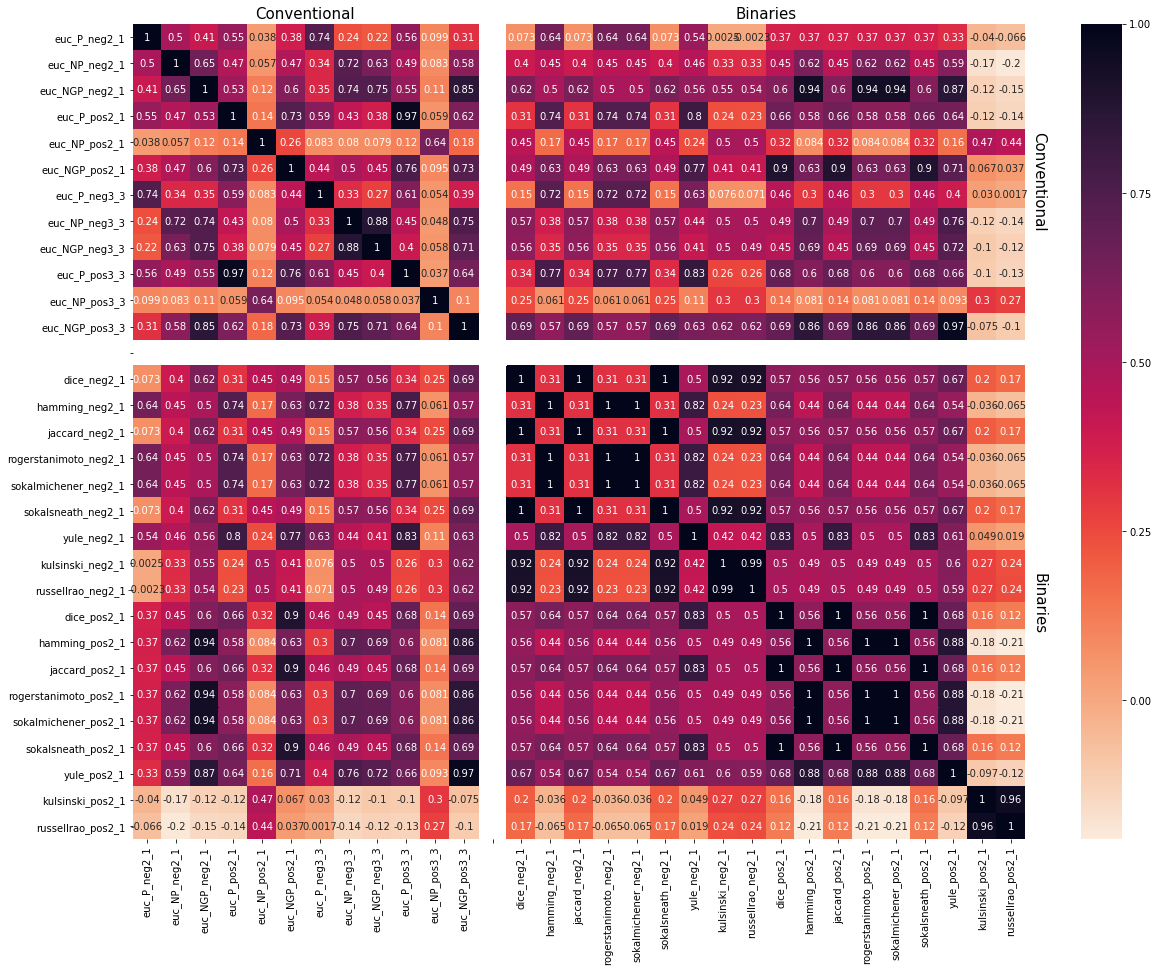

In [80]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

In [81]:
Kendall = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg2_1', 'pos2_1', 'neg3_3', 
                                                                                                'pos3_3','neg+pos'))

for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Kendall.iloc[r,j] = sum(df_K.iloc[12+r,j*3:j*3+3])
        elif j in [1,3]:
            Kendall.iloc[r,j] = sum(df_K.iloc[21+r,j*3:j*3+3])
        else:
            Kendall.iloc[r,j] = sum(Kendall.iloc[r,0:4])
#print(Kendall)

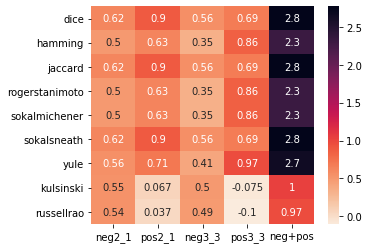

In [82]:
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Kendall.iloc[r,j] = df_K.iloc[12+r,j*3+2]#sum(df_C.iloc[12+r,j*3+2])j*3:j*3+3])
        elif j in [1,3]:
            Kendall.iloc[r,j] = df_K.iloc[21+r,j*3+2]#sum(df_C.iloc[21+r,j*3+2])j*3:j*3+3])
        else:
            Kendall.iloc[r,j] = sum(Kendall.iloc[r,0:4])
f, ax = plt.subplots(figsize=(5, 4))
hm = sns.heatmap(Kendall, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


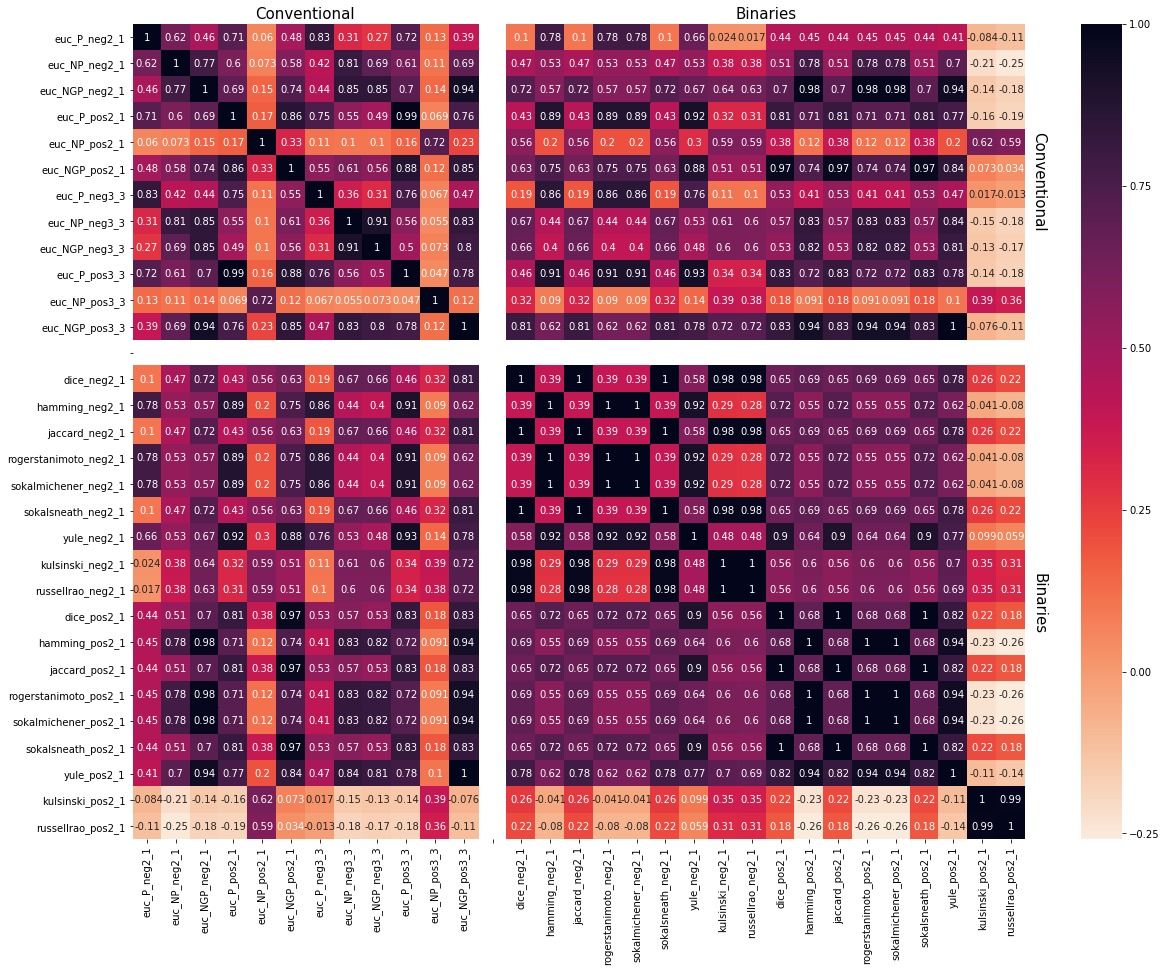

In [83]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


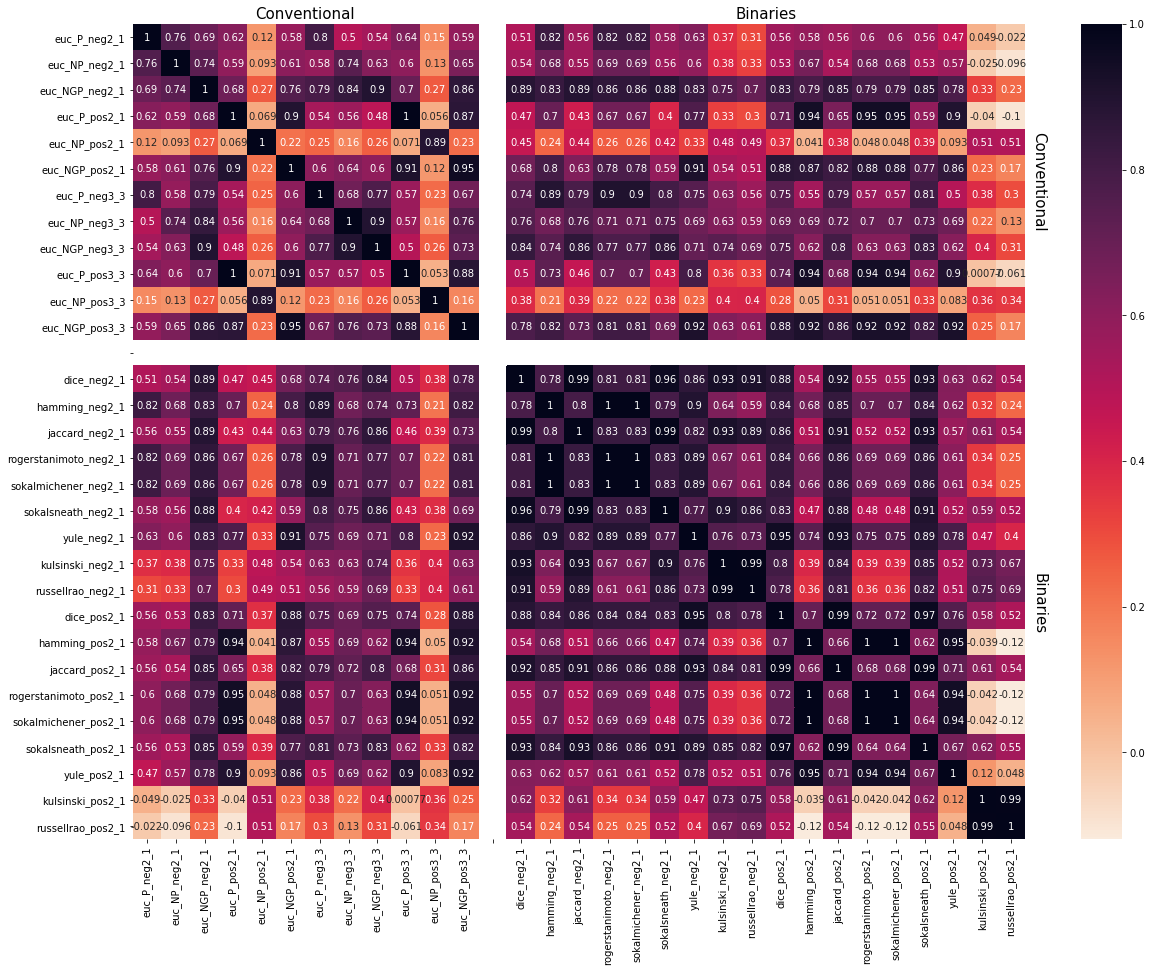

In [84]:
f, ax = plt.subplots(figsize=(20, 15))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

In [85]:
Cophenetic = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg2_1', 'pos2_1', 'neg3_3', 
                                                                                                'pos3_3','neg+pos'))
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Cophenetic.iloc[r,j] = df_C.iloc[12+r,j*3+2]#sum(df_C.iloc[12+r,j*3+2])j*3:j*3+3])
        elif j in [1,3]:
            Cophenetic.iloc[r,j] = df_C.iloc[21+r,j*3+2]#sum(df_C.iloc[21+r,j*3+2])j*3:j*3+3])
        else:
            Cophenetic.iloc[r,j] = sum(Cophenetic.iloc[r,0:4])
#print(Cophenetic)

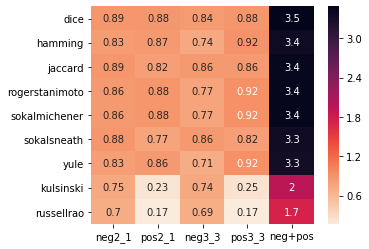

In [86]:
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Cophenetic.iloc[r,j] = df_C.iloc[12+r,j*3+2]#sum(df_C.iloc[12+r,j*3+2])j*3:j*3+3])
        elif j in [1,3]:
            Cophenetic.iloc[r,j] = df_C.iloc[21+r,j*3+2]#sum(df_C.iloc[21+r,j*3+2])j*3:j*3+3])
        else:
            Cophenetic.iloc[r,j] = sum(Cophenetic.iloc[r,0:4])
f, ax = plt.subplots(figsize=(5, 4))
hm = sns.heatmap(Cophenetic, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: neg_peakalignment1, pos_peakalignment1, neg_peakalignment2, pos_peakalignment2, neg_binary, pos_binary

In [87]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[df_K.columns[3*i]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+1]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+2]] = col_lbl2[i]
for i in range(9):
    label_colors2[df_K.columns[12+i]] = col_lbl2[4]
    label_colors2[df_K.columns[21+i]] = col_lbl2[5]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


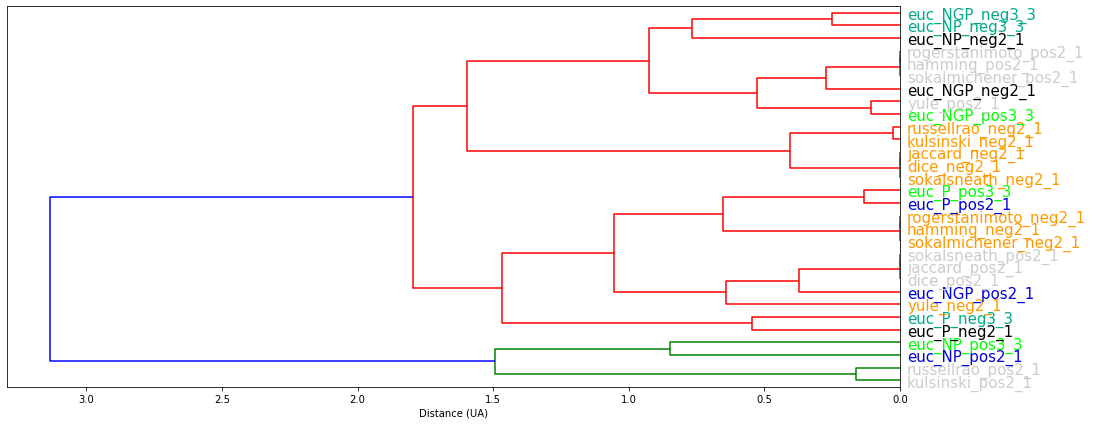

In [88]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_K = hier.linkage(df_K, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=df_K.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


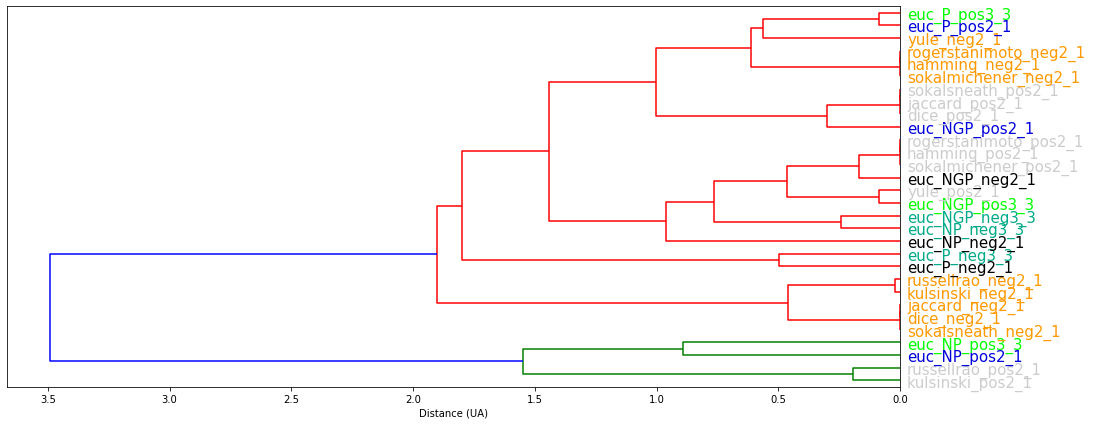

In [89]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_S = hier.linkage(df_S, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=df_S.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


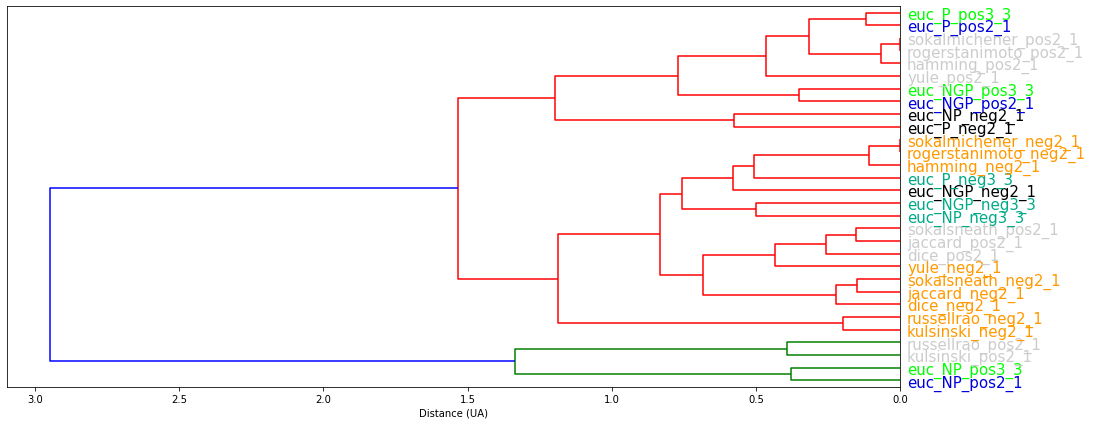

In [90]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_C = hier.linkage(df_C, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=df_C.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [91]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [92]:
disc_average = np.zeros((1,30))
disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30))
for i in range(len(Z)):
    discrim = sca.dist_discrim(aligned_all_neg, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = sca.dist_discrim(aligned_all_neg, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)

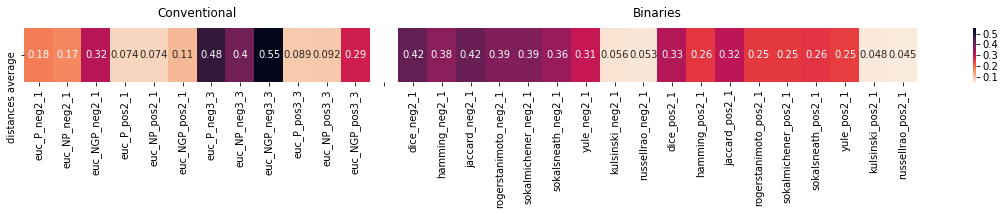

In [93]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(6,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

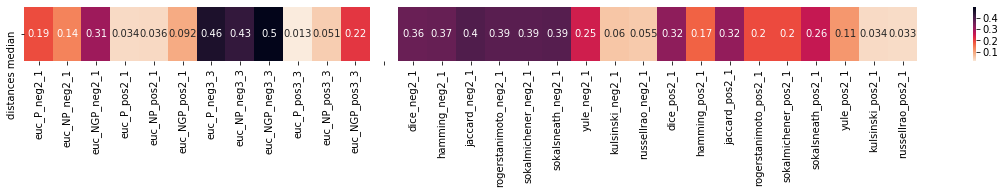

In [94]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

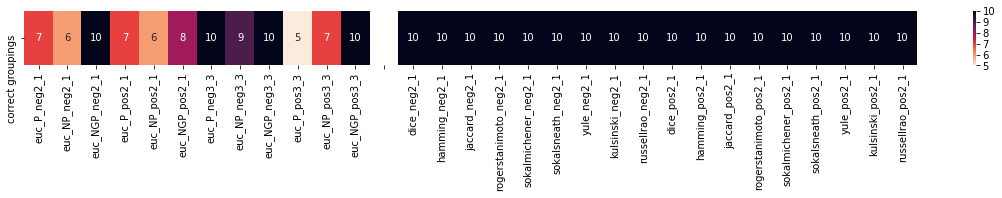

In [95]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [96]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [97]:
Kmean = skclust.KMeans(n_clusters=10)

In [98]:
a = Kmean.fit(Euc_NGP_neg.data.T)

In [99]:
dicto = {}
for i in range(len(a.labels_)):
    if a.labels_[i] in dicto:
        dicto[a.labels_[i]].append(aligned_all_neg.labels[i])
    else:
        dicto[a.labels_[i]] = [aligned_all_neg.labels[i]]
dicto

{5: ['CAN', 'CAN', 'CAN'],
 8: ['CS', 'CS', 'CS'],
 6: ['LAB', 'LAB', 'LAB'],
 4: ['PN', 'PN', 'PN'],
 7: ['REG', 'REG', 'REG'],
 1: ['RIP', 'RIP', 'RIP'],
 3: ['RL', 'RL', 'RL'],
 0: ['ROT', 'ROT', 'ROT'],
 2: ['RU', 'RU', 'RU'],
 9: ['TRI', 'TRI', 'TRI']}

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the Kmeans_discrim function from multianalysis to calculate discrimination distance.

In [100]:
aligned_neg2 = df_to_bool(aligned_all_neg2.data)
aligned_pos2 = df_to_bool(aligned_all_pos2.data)

In [101]:
colnames2 = ['euc_P_neg2_1', 'euc_NP_neg2_1', 'euc_NGP_neg2_1', 'euc_P_pos2_1', 'euc_NP_pos2_1', 'euc_NGP_pos2_1',
             'euc_P_neg3_3', 'euc_NP_neg3_3', 'euc_NGP_neg3_3', 'euc_P_pos3_3', 'euc_NP_pos3_3', 'euc_NGP_pos3_3',
             'aligned_neg2_1', 'aligned_pos2_1','aligned_neg3_3', 'aligned_pos3_3']

In [102]:
euclidean = (Euc_P_neg, Euc_NP_neg, Euc_NGP_neg, Euc_P_pos, Euc_NP_pos, Euc_NGP_pos,
            Euc_P_neg2, Euc_NP_neg2, Euc_NGP_neg2, Euc_P_pos2, Euc_NP_pos2, Euc_NGP_pos2)#, 
binaries = (aligned_neg, aligned_pos, aligned_neg2, aligned_pos2)

In [103]:
from metabolinks import AlignedSpectra

In [104]:
disc_average = np.zeros((1,16))
disc_median = np.zeros((1,16))
disc_correct = np.zeros((1,16))
for i in range(len(euclidean)):
    discrim = ma.Kmeans_discrim(euclidean[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(euclidean[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
for i in range(len(binaries)):
    discrim = ma.Kmeans_discrim(AlignedSpectra(binaries[i], labels = aligned_all_neg.labels), method = 'average')
    disc_average[0,12 + i] 
    disc_average[0,12 + i] = discrim[0]
    disc_median[0,12 + i] = ma.Kmeans_discrim(AlignedSpectra(binaries[i], labels = aligned_all_neg.labels), method = 'median')[0] 
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,12 + i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)

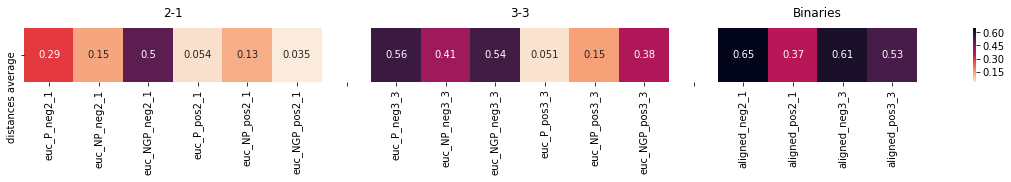

In [105]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'2-1', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'3-3', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

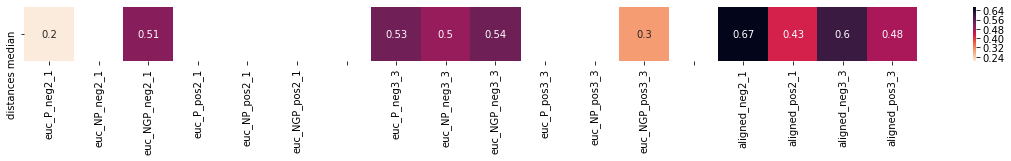

In [106]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

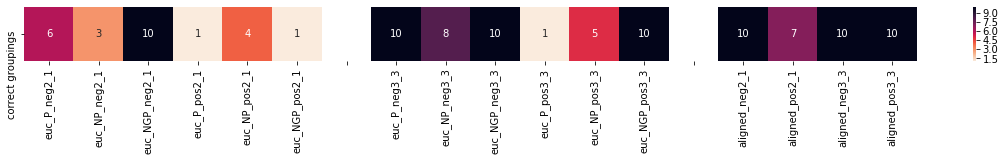

In [107]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 3-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

In [108]:
#Creation of "binary" Spectras using the binary matrices built with the function df_to_bool.
binary_neg1 = AlignedSpectra(aligned_neg.loc[(aligned_neg!=0).any(axis=1)], labels = aligned_all_neg.labels)
binary_neg2 = AlignedSpectra(aligned_neg2.loc[(aligned_neg2!=0).any(axis=1)], labels = aligned_all_neg2.labels)
binary_pos1 = AlignedSpectra(aligned_pos.loc[(aligned_pos!=0).any(axis=1)], labels = aligned_all_pos.labels)
binary_pos2 = AlignedSpectra(aligned_pos2.loc[(aligned_pos2!=0).any(axis=1)], labels = aligned_all_pos2.labels)

### Performance of N, NP and NGP data treatments (alignments 2-1 and 3-3)

See performance of all 3 treatments and absence of them in non-binary data to see which performs the best using method nº1 (simple application of random forests), see below.

In [109]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [110]:
N1_D = ma.simple_RF(Imputated_neg)#, iter_num = 100, n_trees = 500)
Teste['Imp_neg2_1'] = N1_D[0]
Teste_std['Imp_neg2_1'] = np.std(N1_D[0])
Teste_feat['Imp_neg2_1'] = N1_D[1]
N1_D = ma.simple_RF(Euc_P_neg)#, iter_num = 100, n_trees = 500)
Teste['P_neg2_1'] = N1_D[0]
Teste_std['P_neg2_1'] = np.std(N1_D[0])
Teste_feat['P_neg2_1'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NP_neg)#, iter_num = 100, n_trees = 500)
Teste['NP_neg2_1'] = N1_D[0]
Teste_std['NP_neg2_1'] = np.std(N1_D[0])
Teste_feat['NP_neg2_1'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NGP_neg)#, iter_num = 100, n_trees = 500)
Teste['NGP_neg2_1'] = N1_D[0]
Teste_std['NGP_neg2_1'] = np.std(N1_D[0])
Teste_feat['NGP_neg2_1'] = N1_D[1]

BN1_D = ma.simple_RF(binary_neg1)#, iter_num = 100)#)
Teste['bin_neg2_1'] = BN1_D[0]
Teste_std['bin_neg2_1'] = np.std(BN1_D[0])
Teste_feat['bin_neg2_1'] = BN1_D[1]

In [111]:
N1_D = ma.simple_RF(Imputated_pos)#, iter_num = 100, n_trees = 500)
Teste['Imp_pos2_1'] = N1_D[0]
Teste_std['Imp_pos2_1'] = np.std(N1_D[0])
Teste_feat['Imp_pos2_1'] = N1_D[1]
N1_D = ma.simple_RF(Euc_P_pos)#, iter_num = 100, n_trees = 500)
Teste['P_pos2_1'] = N1_D[0]
Teste_std['P_pos2_1'] = np.std(N1_D[0])
Teste_feat['P_pos2_1'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NP_pos)#, iter_num = 100, n_trees = 500)
Teste['NP_pos2_1'] = N1_D[0]
Teste_std['NP_pos2_1'] = np.std(N1_D[0])
Teste_feat['NP_pos2_1'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NGP_pos)#, iter_num = 100, n_trees = 500)
Teste['NGP_pos2_1'] = N1_D[0]
Teste_std['NGP_pos2_1'] = np.std(N1_D[0])
Teste_feat['NGP_pos2_1'] = N1_D[1]

BN1_D = ma.simple_RF(binary_pos1)#, iter_num = 100)#)
Teste['bin_pos2_1'] = BN1_D[0]
Teste_std['bin_pos2_1'] = np.std(BN1_D[0])
Teste_feat['bin_pos2_1'] = BN1_D[1]


In [112]:
N1_D = ma.simple_RF(Imputated_neg2)#, iter_num = 100, n_trees = 500)
Teste['Imp_neg3_3'] = N1_D[0]
Teste_std['Imp_neg3_3'] = np.std(N1_D[0])
Teste_feat['Imp_neg3_3'] = N1_D[1]
N1_D = ma.simple_RF(Euc_P_neg2)#, iter_num = 100, n_trees = 500)
Teste['P_neg3_3'] = N1_D[0]
Teste_std['P_neg3_3'] = np.std(N1_D[0])
Teste_feat['P_neg3_3'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NP_neg2)#, iter_num = 100, n_trees = 500)
Teste['NP_neg3_3'] = N1_D[0]
Teste_std['NP_neg3_3'] = np.std(N1_D[0])
Teste_feat['NP_neg3_3'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NGP_neg2)#, iter_num = 100, n_trees = 500)
Teste['NGP_neg3_3'] = N1_D[0]
Teste_std['NGP_neg3_3'] = np.std(N1_D[0])
Teste_feat['NGP_neg3_3'] = N1_D[1]

BN1_D = ma.simple_RF(binary_neg2)#, iter_num = 100)#
Teste['bin_neg3_3'] = np.mean(BN1_D[0])
Teste_std['bin_neg3_3'] = np.std(BN1_D[0])
Teste_feat['bin_neg3_3'] = BN1_D[1]

In [113]:
N1_D = ma.simple_RF(Imputated_pos2)#, iter_num = 100, n_trees = 500)
Teste['Imp_pos3_3'] = N1_D[0]
Teste_std['Imp_pos3_3'] = np.std(N1_D[0])
Teste_feat['Imp_pos3_3'] = N1_D[1]
N1_D = ma.simple_RF(Euc_P_pos2)#, iter_num = 100, n_trees = 500)
Teste['P_pos3_3'] = N1_D[0]
Teste_std['P_pos3_3'] = np.std(N1_D[0])
Teste_feat['P_pos3_3'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NP_pos2)#, iter_num = 100, n_trees = 500)
Teste['NP_pos3_3'] = N1_D[0]
Teste_std['NP_pos3_3'] = np.std(N1_D[0])
Teste_feat['NP_pos3_3'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NGP_pos2)#, iter_num = 100, n_trees = 500)
Teste['NGP_pos3_3'] = N1_D[0]
Teste_std['NGP_pos3_3'] = np.std(N1_D[0])
Teste_feat['NGP_pos3_3'] = N1_D[1]

BN1_D = ma.simple_RF(binary_pos2)#, iter_num = 100)#
Teste['bin_pos3_3'] = BN1_D[0]
Teste_std['bin_pos3_3'] = np.std(BN1_D[0])
Teste_feat['bin_pos3_3'] = BN1_D[1]

Accuracy based on the dataset


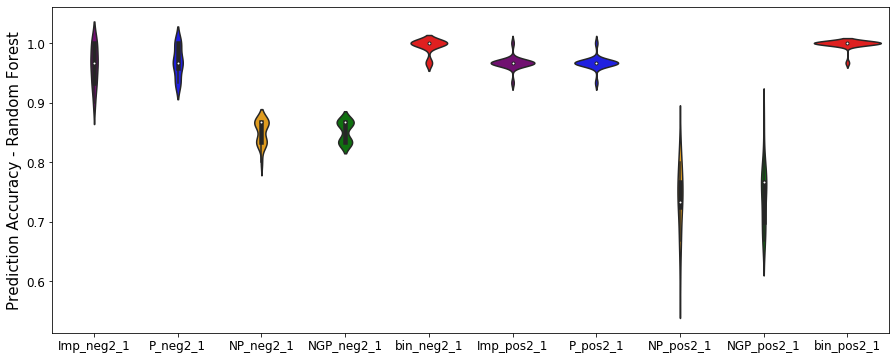

In [114]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['purple','blue','orange','green','red']
data = pd.DataFrame.from_dict(Teste)
sns.violinplot( data = data.iloc[:,:10], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

Accuracy based on the dataset


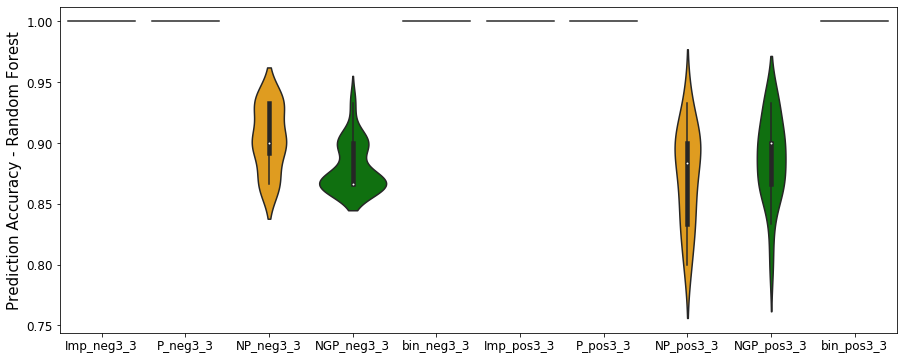

In [115]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data.iloc[:,10:], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

In [116]:
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.mean(Teste[i])

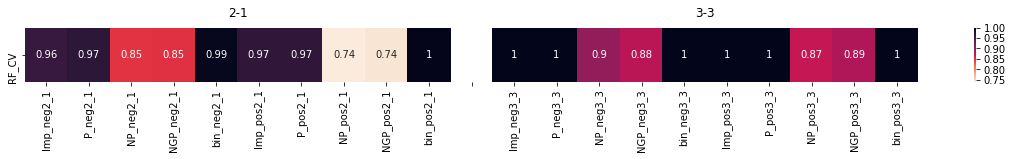

In [117]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Teste_H = pd.concat([Teste_H.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_H.iloc[:,10:]], axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])
plt.text(5,-0.2,'2-1', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'3-3', fontsize  = 12, horizontalalignment='center')
plt.show()

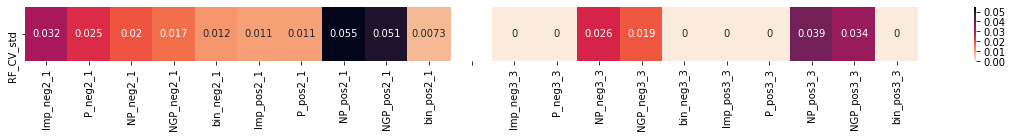

In [118]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste_A.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Teste_std_H = pd.concat([Teste_std_H.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_std_H.iloc[:,10:]], 
                        axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [119]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste_A.keys()).T
Teste_ic = Teste_std_H / (100**0.5)*1.96

In [120]:
#sns.set_context('notebook')

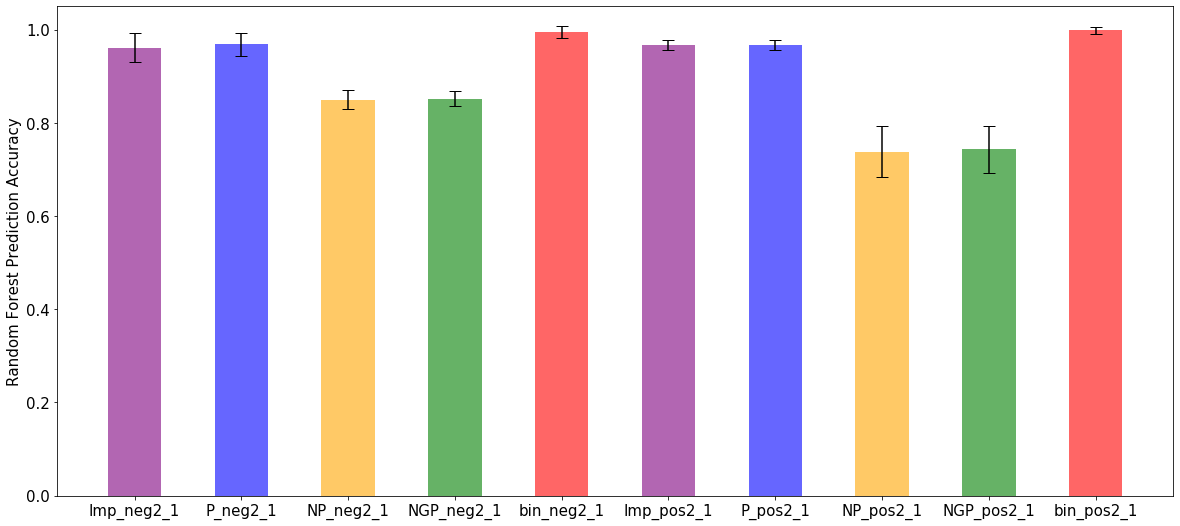

In [121]:
f, ax = plt.subplots(figsize=(20, 9))
#sns.set_context('talk')
color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][0:10], x = Teste_H.columns[0:10], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[0:10], y = Teste_H.T['Accuracy'][0:10], yerr = Teste_std_H.iloc[0,:10], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

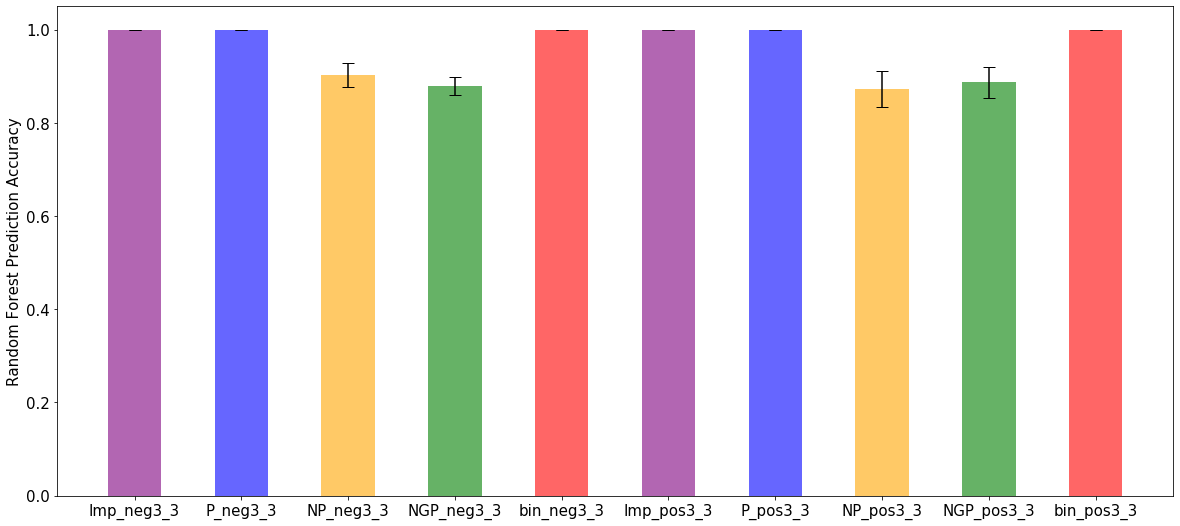

In [122]:
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][10:], x = Teste_H.columns[10:], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[10:], y = Teste_H.T['Accuracy'][10:], yerr = Teste_std_H.iloc[0,10:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

#### Applications of different methods

In [123]:
#Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

### Attempt/Method nº1 - Direct

### Simple application of random forests

Since the dataset is small, the random forest classification is iterated 20 times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained - number of random forests can be decided by iter_num. This is the same for all methods. 

To offset the small dataset, 3-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/accuracy (3-fold since that is maximum number possible since every group of samples only has 3 replicates.

Besides the 3-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weight) is extracted from the forests "built".

Now to run the random forests on the different datasets (negative and positive of both alignments) both in their "normal" and "binary" matrices form. For the normal or euclidean matrices, only the data concerning the P data processing was used since it was the best performer of all former methods employed.

Application of the function simple_RF from multianalysis.

In [124]:
N1_D = ma.simple_RF(Euc_P_neg)#(Scores, Cohen's Kappa Score, order of features based on importances, 3-fold cross-validation)
Scores['neg2-1_direct'] = np.mean(N1_D[0])
Scores_std['neg2-1_direct'] = np.std(N1_D[0])
Imp_feat['neg2-1_direct'] = N1_D[1]

In [125]:
P1_D = ma.simple_RF(Euc_P_pos)
Scores['pos2-1_direct'] = np.mean(P1_D[0])
Scores_std['pos2-1_direct'] = np.std(P1_D[0])
Imp_feat['pos2-1_direct'] = P1_D[1]

In [126]:
N2_D = ma.simple_RF(Euc_P_neg2)
Scores['neg3-3_direct'] = np.mean(N2_D[0])
Scores_std['neg3-3_direct'] = np.std(N2_D[0])
Imp_feat['neg3-3_direct'] = N2_D[1]

In [127]:
P2_D = ma.simple_RF(Euc_P_pos2)
Scores['pos3-3_direct'] = np.mean(P2_D[0])
Scores_std['pos3-3_direct'] = np.std(P2_D[0])
Imp_feat['pos3-3_direct'] = P2_D[1]

In [128]:
BN1_D = ma.simple_RF(binary_neg1)
Scores['neg2-1_bin_direct'] = np.mean(BN1_D[0])
Scores_std['neg2-1_bin_direct'] = np.std(BN1_D[0])
Imp_feat['neg2-1_bin_direct'] = BN1_D[1]

In [129]:
BP1_D = ma.simple_RF(binary_pos1)
Scores['pos2-1_bin_direct'] = np.mean(BP1_D[0])
Scores_std['pos2-1_bin_direct'] = np.std(BP1_D[0])
Imp_feat['pos2-1_bin_direct'] = BP1_D[1]

In [130]:
BN2_D = ma.simple_RF(binary_neg2)
Scores['neg3-3_bin_direct'] = np.mean(BN2_D[0])
Scores_std['neg3-3_bin_direct'] = np.std(BN2_D[0])
Imp_feat['neg3-3_bin_direct'] = BN2_D[1]

In [131]:
BP2_D = ma.simple_RF(binary_pos2)
Scores['pos3-3_bin_direct'] = np.mean(BP2_D[0])
Scores_std['pos3-3_bin_direct'] = np.std(BP2_D[0])
Imp_feat['pos3-3_bin_direct'] = BP2_D[1]

### Attempt/Method nº2 - SMOTE

### Oversampling data with SMOTE before splitting cross-validation groups. Expected better results due to bleed.

All the same specifications as method nº1 but with an oversampling of the data that doubles the amount of samples (from 39 to 78) which means each cross-valdiation group will have 2 replicates for each variety instead of one.

As mentioned in the title, this means there will be a "bleeding" of the data between test and training groups due to the samples in the test group having been originated from the ones in the training group or have been used to originate data in training groups. Therefore, the score of this method should be higher than the other due to an overestimation of how good the model is due to this bleeding.

SMOTE oversampling is performed in the initial imputated data by the function fast_SMOTE from multianalysis.py. 

Therefore we have to run the NGP data processing again for each dataset.

In [132]:
#Neg1
Imp_S_neg = ma.fast_SMOTE(Imputated_neg)
#Norm_S_neg = sca.Norm_Feat(Imp_S_neg, 554.26202)
#glog_S_neg = sca.glog(Norm_S_neg)
Euc_P_S_neg = sca.ParetoScal(Imp_S_neg)#glog_S_neg)
#Neg2
Imp_S_neg2 = ma.fast_SMOTE(Imputated_neg2)
#Norm_S_neg2 = sca.Norm_Feat(Imp_S_neg2, 554.26202)
#glog_S_neg2 = sca.glog(Norm_S_neg2)
Euc_P_S_neg2 = sca.ParetoScal(Imp_S_neg2)#glog_S_neg2)
#Pos1
Imp_S_pos = ma.fast_SMOTE(Imputated_pos)
#Norm_S_pos = sca.Norm_Feat(Imp_S_pos, 556.2765712820513)
#glog_S_pos = sca.glog(Norm_S_pos)
Euc_P_S_pos = sca.ParetoScal(Imp_S_pos)#glog_S_pos)
#Pos2
Imp_S_pos2 = ma.fast_SMOTE(Imputated_pos2)
#Norm_S_pos2 = sca.Norm_Feat(Imp_S_pos2, 556.2765712820513)
#glog_S_pos2 = sca.glog(Norm_S_pos2)
Euc_P_S_pos2 = sca.ParetoScal(Imp_S_pos2)#glog_S_pos2)
#Binaries
binary_S_neg1 = ma.fast_SMOTE(binary_neg1, binary = True)
binary_S_neg2 = ma.fast_SMOTE(binary_neg2, binary = True)
binary_S_pos1 = ma.fast_SMOTE(binary_pos1, binary = True)
binary_S_pos2 = ma.fast_SMOTE(binary_pos2, binary = True)

In [133]:
N1_B = ma.simple_RF(Euc_P_S_neg)
Scores['neg2-1_bleed'] = np.mean(N1_B[0])
Scores_std['neg2-1_bleed'] = np.std(N1_B[0])
Imp_feat['neg2-1_bleed'] = N1_B[1]

In [134]:
P1_B = ma.simple_RF(Euc_P_S_pos)
Scores['pos2-1_bleed'] = np.mean(P1_B[0])
Scores_std['pos2-1_bleed'] = np.std(P1_B[0])
Imp_feat['pos2-1_bleed'] = P1_B[1]

In [135]:
N2_B = ma.simple_RF(Euc_P_S_neg2)
Scores['neg3-3_bleed'] = np.mean(N2_B[0])
Scores_std['neg3-3_bleed'] = np.std(N2_B[0])
Imp_feat['neg3-3_bleed'] = N2_B[1]

In [136]:
P2_B = ma.simple_RF(Euc_P_S_pos2)
Scores['pos3-3_bleed'] = np.mean(P2_B[0])
Scores_std['pos3-3_bleed'] = np.std(P2_B[0])
Imp_feat['pos3-3_bleed'] = P2_B[1]

In [137]:
BN1_B = ma.simple_RF(binary_S_neg1)
Scores['neg2-1_bin_bleed'] = np.mean(BN1_B[0])
Scores_std['neg2-1_bin_bleed'] = np.std(BN1_B[0])
Imp_feat['neg2-1_bin_bleed'] = BN1_B[1]

In [138]:
BP1_B = ma.simple_RF(binary_S_pos1)
Scores['pos2-1_bin_bleed'] = np.mean(BP1_B[0])
Scores_std['pos2-1_bin_bleed'] = np.std(BP1_B[0])
Imp_feat['pos2-1_bin_bleed'] = BP1_B[1]

In [139]:
BN2_B = ma.simple_RF(binary_S_neg2)
Scores['neg3-3_bin_bleed'] = np.mean(BN2_B[0])
Scores_std['neg3-3_bin_bleed'] = np.std(BN2_B[0])
Imp_feat['neg3-3_bin_bleed'] = BN2_B[1]

In [140]:
BP2_B = ma.simple_RF(binary_S_pos2)
Scores['pos3-3_bin_bleed'] = np.mean(BP2_B[0])
Scores_std['pos3-3_bin_bleed'] = np.std(BP2_B[0])
Imp_feat['pos3-3_bin_bleed'] = BP2_B[1]

### Attempt/Method nº3 - Afterproc (Euclidean); Aftersplit (Binary)
Oversampling data with SMOTE after splitting data and after treatment of data (NGP) (binary matrixes don't have any further processing) - Problem: SMOTE after data processing isn't quite the same as in the beginning of the data (vectors between transformed data in different scale than original)

All the same specifications as method nº1.

#### Still possible although probably not very useful, as for now, it won't be implemented in the notebook (method nº4 is the same but completely excised of the notebook.

Application of the function RF_M3 from multianalysis.

### Results of the Random Forests surmised in Heatmaps

In [141]:
Scores_H = pd.DataFrame(list(Scores.values()), index = Scores.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

#Inserting blank lines in the DataFrame for better presentation and separation
Scores_H = pd.concat([Scores_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Scores_H.iloc[:,8:]], axis = 1)
Scores_std_H = pd.concat([Scores_std_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Scores_std_H.iloc[:,8:]], 
                        axis = 1)

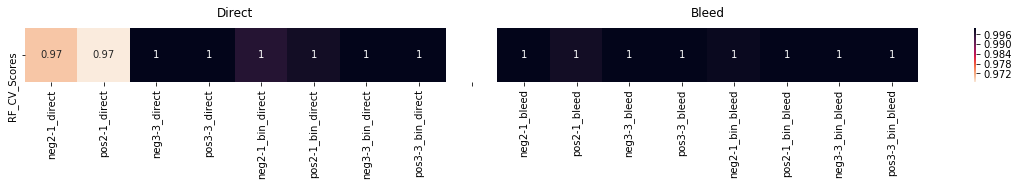

In [142]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])
plt.text(4,-0.2,'Direct', fontsize  = 12, horizontalalignment='center')
plt.text(13,-0.2,'Bleed', fontsize  = 12, horizontalalignment='center')
plt.show()

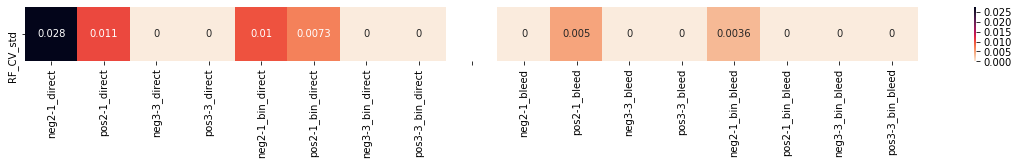

In [143]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive)

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A scatter plot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

### Alignments 2-1 and 3-3

In [144]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature and calculating
#% explained by these features (more)
ev = []
magni = []
more = []
bxpl = pd.DataFrame(columns = Imp_feat)
for j in Imp_feat:#['neg2-1_direct']:
    if j.startswith('neg2-1'):
        Spectra = aligned_all_neg
    elif j.startswith('pos2-1'):
        Spectra = aligned_all_pos
    elif j.startswith('neg3-3'):
        #continue
        Spectra = aligned_all_neg2
    elif j.startswith('pos3-3'):
        #continue
        Spectra = aligned_all_pos2
    ratio = []
    nsamples = []
    n_groups = []
    number = round(0.02*len(Spectra))
    magni.append(Imp_feat[j][0][1]/(1/len(Spectra)))
    a = 0
    for i in range(number): 
        a = a + Imp_feat[j][i][1]*100 
        ngroups = {}
        line = Spectra.data.loc[Imp_feat[j][i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    bxpl[j] = df['nsamples']
    ev.append(df)
#print(ev[4])

In [145]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Imp_feat]) #if '2-1' in i])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8], line, df.iloc[8:12], line, df.iloc[12:]])

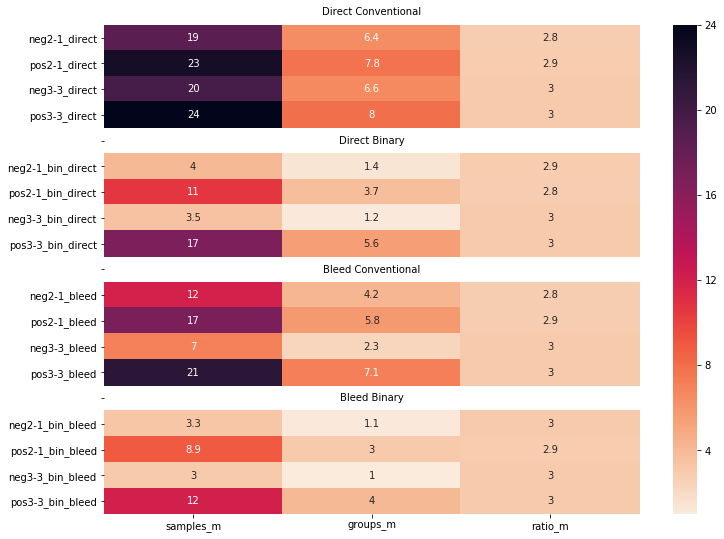

In [146]:
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Direct Conventional',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Direct Binary',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,9.5,'Bleed Conventional',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,14.5,'Bleed Binary',horizontalalignment='center', verticalalignment='center')
plt.show()

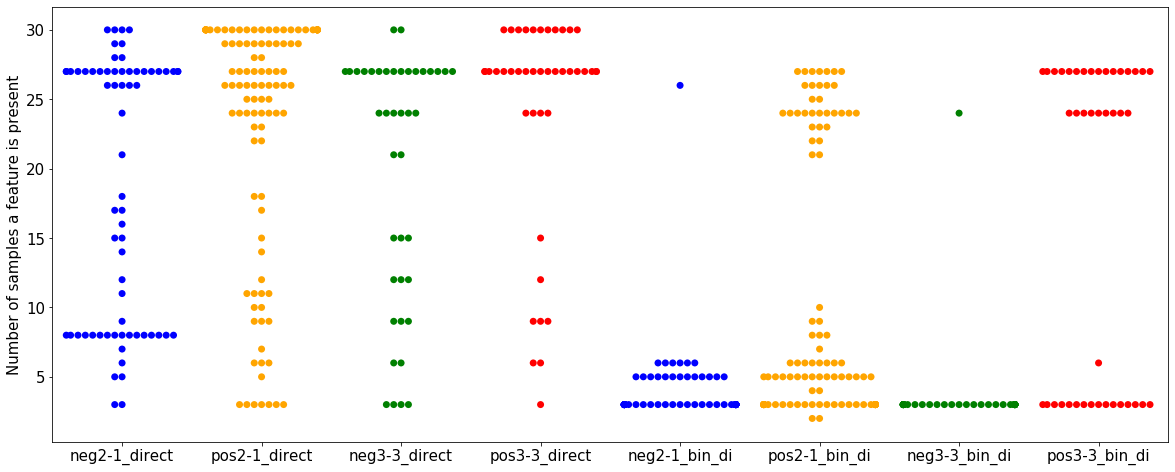

In [147]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[:8], size = 7, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(Imp_feat.keys())[i][0:13] for i in range(len(Imp_feat.keys()))][:8])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [148]:
print('Magnitude of most important feature:', magni)
print('% of model explained by the 2% most important features', more)

Magnitude of most important feature: [3.7403593880759884, 9.192370731985834, 4.021941720706502, 6.089760583434672, 4.128501032367807, 8.656116708850691, 4.177579916483431, 5.316091504786322, 3.8801478593618257, 9.971414031999602, 3.623211616787441, 5.974506786297347, 6.049930772958983, 12.411726118604475, 4.460356802854391, 6.003755364863874]
% of model explained by the 2% most important features [5.955103743726807, 12.009666874924894, 5.423663975349363, 9.300244496865327, 5.88084804667486, 10.360963605986923, 6.965089576780393, 8.870836691186097, 6.2951520034755175, 12.152120616310295, 5.820182887992224, 9.932407594894244, 8.456489283230155, 14.65711650179257, 7.696986582297411, 9.89334834166251]


### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

In [149]:
CV = {}
PMs = {}
pvalue = {}

In [150]:
permuta = ma.permutation_RF(Euc_P_neg, iter_num = 150, n_fold = 3)
CV['P_neg'] = permuta[0]
PMs['P_neg'] = permuta[1]
pvalue['P_neg'] = permuta[2]

permuta = ma.permutation_RF(Euc_NP_neg, iter_num = 150, n_fold = 3)
CV['NP_neg'] = permuta[0]
PMs['NP_neg'] = permuta[1]
pvalue['NP_neg'] = permuta[2]

In [151]:
permuta = ma.permutation_RF(Euc_NGP_neg, iter_num = 150, n_fold = 3)
CV['NGP_neg'] = permuta[0]
PMs['NGP_neg'] = permuta[1]
pvalue['NGP_neg'] = permuta[2]

permuta = ma.permutation_RF(binary_neg1, iter_num = 150, n_fold = 3)
CV['bin_neg'] = permuta[0]
PMs['bin_neg'] = permuta[1]
pvalue['bin_neg'] = permuta[2]

In [152]:
permuta = ma.permutation_RF(Euc_P_pos, iter_num = 150, n_fold = 3)
CV['P_pos'] = permuta[0]
PMs['P_pos'] = permuta[1]
pvalue['P_pos'] = permuta[2]

permuta = ma.permutation_RF(Euc_NP_pos, iter_num = 150, n_fold = 3)
CV['NP_pos'] = permuta[0]
PMs['NP_pos'] = permuta[1]
pvalue['NP_pos'] = permuta[2]

In [153]:
permuta = ma.permutation_RF(Euc_NGP_pos, iter_num = 150, n_fold = 3)
CV['NGP_pos'] = permuta[0]
PMs['NGP_pos'] = permuta[1]
pvalue['NGP_pos'] = permuta[2]

permuta = ma.permutation_RF(binary_pos1, iter_num = 150, n_fold = 3)
CV['bin_pos'] = permuta[0]
PMs['bin_pos'] = permuta[1]
pvalue['bin_pos'] = permuta[2]

In [154]:
permuta = ma.permutation_RF(Euc_P_neg2, iter_num = 150, n_fold = 3)
CV['P_neg2'] = permuta[0]
PMs['P_neg2'] = permuta[1]
pvalue['P_neg2'] = permuta[2]

permuta = ma.permutation_RF(Euc_NP_neg2, iter_num = 150, n_fold = 3)
CV['NP_neg2'] = permuta[0]
PMs['NP_neg2'] = permuta[1]
pvalue['NP_neg2'] = permuta[2]

In [155]:
permuta = ma.permutation_RF(Euc_NGP_neg2, iter_num = 150, n_fold = 3)
CV['NGP_neg2'] = permuta[0]
PMs['NGP_neg2'] = permuta[1]
pvalue['NGP_neg2'] = permuta[2]

permuta = ma.permutation_RF(binary_neg2, iter_num = 150, n_fold = 3)
CV['bin_neg2'] = permuta[0]
PMs['bin_neg2'] = permuta[1]
pvalue['bin_neg2'] = permuta[2]

In [156]:
permuta = ma.permutation_RF(Euc_P_pos2, iter_num = 150, n_fold = 3)
CV['P_pos2'] = permuta[0]
PMs['P_pos2'] = permuta[1]
pvalue['P_pos2'] = permuta[2]

permuta = ma.permutation_RF(Euc_NP_pos2, iter_num = 150, n_fold = 3)
CV['NP_pos2'] = permuta[0]
PMs['NP_pos2'] = permuta[1]
pvalue['NP_pos2'] = permuta[2]

In [157]:
permuta = ma.permutation_RF(Euc_NGP_pos2, iter_num = 150, n_fold = 3)
CV['NGP_pos2'] = permuta[0]
PMs['NGP_pos2'] = permuta[1]
pvalue['NGP_pos2'] = permuta[2]

permuta = ma.permutation_RF(binary_pos2, iter_num = 150, n_fold = 3)
CV['bin_pos2'] = permuta[0]
PMs['bin_pos2'] = permuta[1]
pvalue['bin_pos2'] = permuta[2]

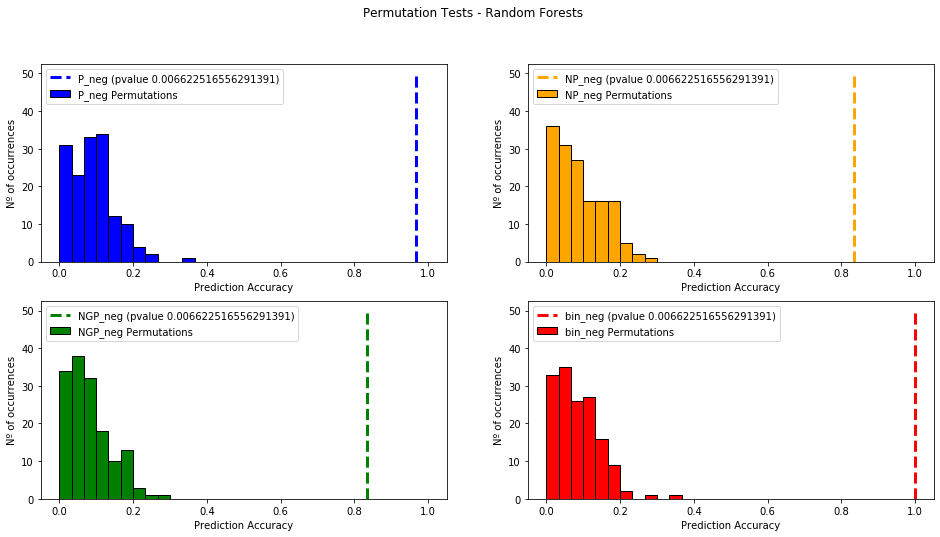

In [158]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'bin_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

plt.suptitle('Permutation Tests - Random Forests')

for i in range(len(Names)):
    quadrant[i].hist(PMs[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

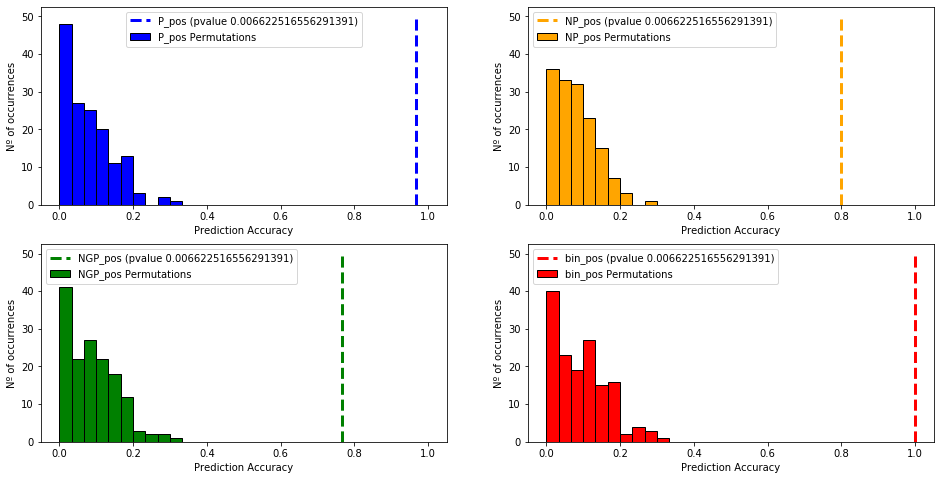

In [159]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'bin_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
for i in range(len(Names)):
    quadrant[i].hist(PMs[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

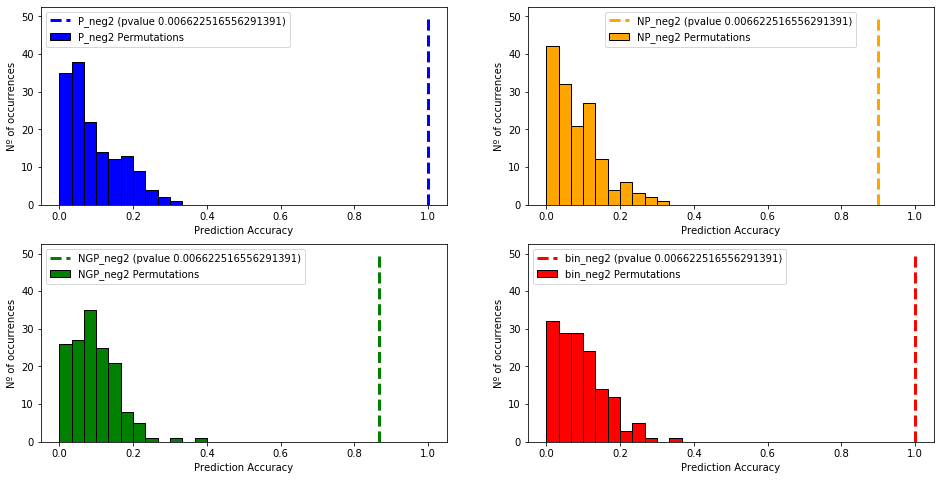

In [160]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
for i in range(len(Names)):
    quadrant[i].hist(PMs[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

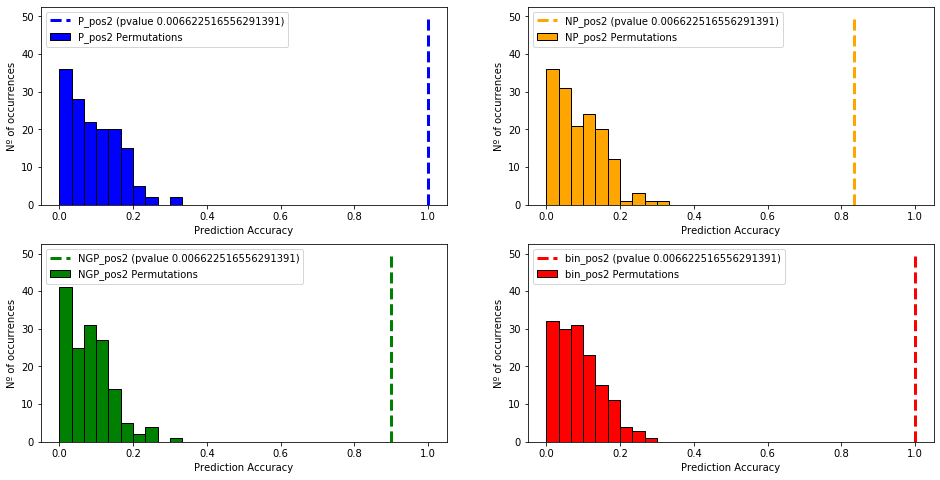

In [161]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
for i in range(len(Names)):
    quadrant[i].hist(PMs[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [162]:
matrix = pd.get_dummies(aligned_all_neg.labels)
matrix = matrix[['CAN','CS','LAB','PN','REG','RIP','RL','ROT','RU','TRI']]

## Alignment 2-1

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function optim_PLS in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [163]:
%%capture
#PLS applied in the negative dataset.
P_neg_PLS = ma.optim_PLS(Euc_P_neg, matrix, max_comp = 50)
NP_neg_PLS = ma.optim_PLS(Euc_NP_neg, matrix, max_comp = 50)
NGP_neg_PLS = ma.optim_PLS(Euc_NGP_neg, matrix, max_comp = 50)
bin_neg_PLS = ma.optim_PLS(binary_neg1, matrix, max_comp = 50)

#PLS applied in the positive dataset.
P_pos_PLS = ma.optim_PLS(Euc_P_pos, matrix, max_comp = 50)
NP_pos_PLS = ma.optim_PLS(Euc_NP_pos, matrix, max_comp = 50)
NGP_pos_PLS = ma.optim_PLS(Euc_NGP_pos, matrix, max_comp = 50)
bin_pos_PLS = ma.optim_PLS(binary_pos1, matrix, max_comp = 50)

Performance based on number of components - Alignment: 2-1, Negative Mode


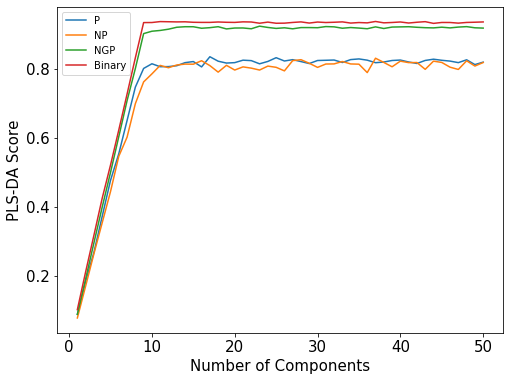

In [164]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_neg_PLS[0])
plt.plot(range(1,51),NP_neg_PLS[0])
plt.plot(range(1,51),NGP_neg_PLS[0])
plt.plot(range(1,51),bin_neg_PLS[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 2-1, Negative Mode')

Performance based on number of components - Alignment: 2-1, Negative Mode


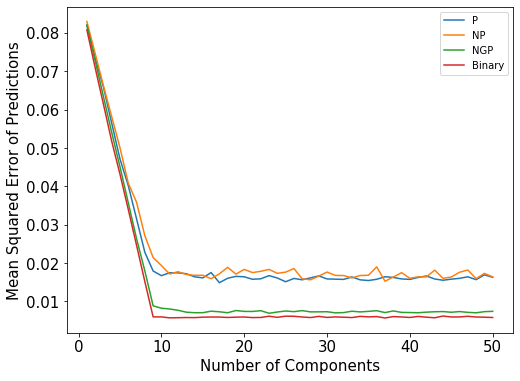

In [165]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_neg_PLS[2])
plt.plot(range(1,51),NP_neg_PLS[2])
plt.plot(range(1,51),NGP_neg_PLS[2])
plt.plot(range(1,51),bin_neg_PLS[2])
plt.ylabel('Mean Squared Error of Predictions', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 2-1, Negative Mode')

Performance based on number of components - Alignment: 2-1, Negative Mode


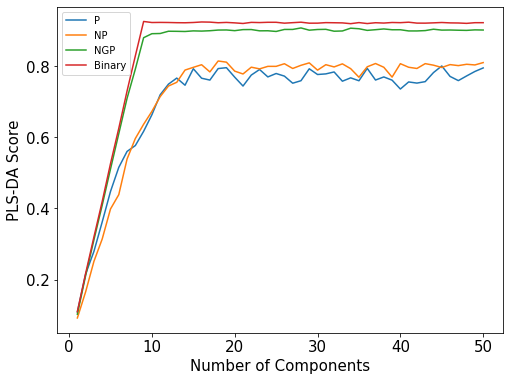

In [166]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_pos_PLS[0])
plt.plot(range(1,51),NP_pos_PLS[0])
plt.plot(range(1,51),NGP_pos_PLS[0])
plt.plot(range(1,51),bin_pos_PLS[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 2-1, Negative Mode')

Performance based on number of components - Alignment: 2-1, Negative Mode


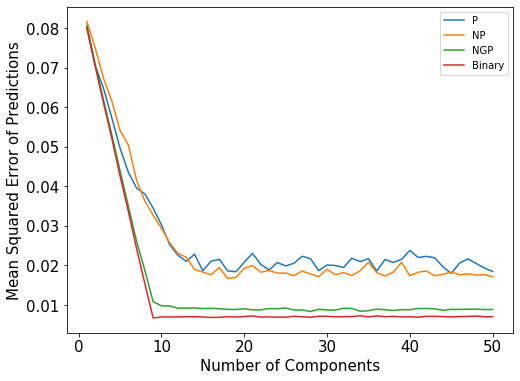

In [167]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_pos_PLS[2])
plt.plot(range(1,51),NP_pos_PLS[2])
plt.plot(range(1,51),NGP_pos_PLS[2])
plt.plot(range(1,51),bin_pos_PLS[2])
plt.ylabel('Mean Squared Error of Predictions', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 2-1, Negative Mode')

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better when it reached around 15. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [168]:
PLS_accu = {}
PLS_score = {}
PLS_Feat = {}

In [169]:
%%capture
P_neg_PLS = ma.model_PLSDA(Euc_P_neg, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['P_neg'] = P_neg_PLS[0]
PLS_score['P_neg'] = P_neg_PLS[1]
PLS_Feat['P_neg'] = P_neg_PLS[3]

NP_neg_PLS = ma.model_PLSDA(Euc_NP_neg, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['NP_neg'] = NP_neg_PLS[0]
PLS_score['NP_neg'] = NP_neg_PLS[1]
PLS_Feat['NP_neg'] = NP_neg_PLS[3]

NGP_neg_PLS = ma.model_PLSDA(Euc_NGP_neg, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['NGP_neg'] = NGP_neg_PLS[0]
PLS_score['NGP_neg'] = NGP_neg_PLS[1]
PLS_Feat['NGP_neg'] = NGP_neg_PLS[3]

bin_neg_PLS = ma.model_PLSDA(binary_neg1, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['bin_neg'] = bin_neg_PLS[0]
PLS_score['bin_neg'] = bin_neg_PLS[1]
PLS_Feat['bin_neg'] = bin_neg_PLS[3]

In [170]:
%%capture
P_pos_PLS = ma.model_PLSDA(Euc_P_pos, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['P_pos'] = P_pos_PLS[0]
PLS_score['P_pos'] = P_pos_PLS[1]
PLS_Feat['P_pos'] = P_pos_PLS[3]

NP_pos_PLS = ma.model_PLSDA(Euc_NP_pos, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['NP_pos'] = NP_pos_PLS[0]
PLS_score['NP_pos'] = NP_pos_PLS[1]
PLS_Feat['NP_pos'] = NP_pos_PLS[3]

NGP_pos_PLS = ma.model_PLSDA(Euc_NGP_pos, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['NGP_pos'] = NGP_pos_PLS[0]
PLS_score['NGP_pos'] = NGP_pos_PLS[1]
PLS_Feat['NGP_pos'] = NGP_pos_PLS[3]

bin_pos_PLS = ma.model_PLSDA(binary_pos1, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['bin_pos'] = bin_pos_PLS[0]
PLS_score['bin_pos'] = bin_pos_PLS[1]
PLS_Feat['bin_pos'] = bin_pos_PLS[3]

Accuracy based on the dataset - Alignment: 2-1, Negative and Positive Mode


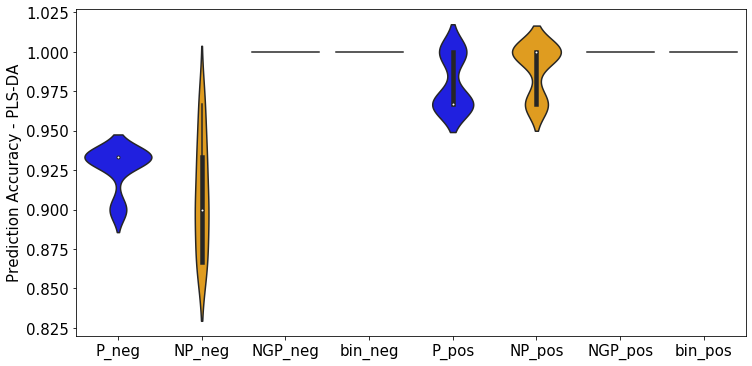

In [171]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['blue','orange','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
print('Accuracy based on the dataset - Alignment: 2-1, Negative and Positive Mode')

Performance score based on the dataset - Alignment: 2-1, Negative and Positive Mode


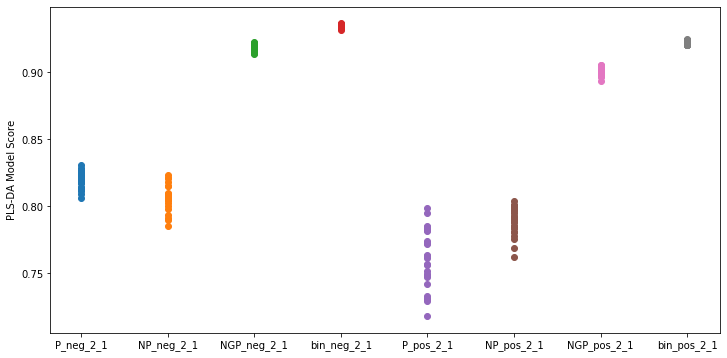

In [172]:
f, ax = plt.subplots(figsize=(12,6))
plt.scatter(['P_neg_2_1']*len(PLS_score['P_neg']), PLS_score['P_neg'])
plt.scatter(['NP_neg_2_1']*len(PLS_score['NP_neg']), PLS_score['NP_neg'])
plt.scatter(['NGP_neg_2_1']*len(PLS_score['NGP_neg']), PLS_score['NGP_neg'])
plt.scatter(['bin_neg_2_1']*len(PLS_score['bin_neg']), PLS_score['bin_neg'])
plt.scatter(['P_pos_2_1']*len(PLS_score['P_pos']), PLS_score['P_pos'])
plt.scatter(['NP_pos_2_1']*len(PLS_score['NP_pos']), PLS_score['NP_pos'])
plt.scatter(['NGP_pos_2_1']*len(PLS_score['NGP_pos']), PLS_score['NGP_pos'])
plt.scatter(['bin_pos_2_1']*len(PLS_score['bin_pos']), PLS_score['bin_pos'])
plt.ylabel('PLS-DA Model Score')
print('Performance score based on the dataset - Alignment: 2-1, Negative and Positive Mode')

In [173]:
Accuracy = {}
Accuracy['P_neg_2_1'] = np.mean(PLS_accu['P_neg'])
Accuracy['NP_neg_2_1'] = np.mean(PLS_accu['NP_neg'])
Accuracy['NGP_neg_2_1'] = np.mean(PLS_accu['NGP_neg'])
Accuracy['bin_neg_2_1'] = np.mean(PLS_accu['bin_neg'])
Accuracy['P_pos_2_1'] = np.mean(PLS_accu['P_pos'])
Accuracy['NP_pos_2_1'] = np.mean(PLS_accu['NP_pos'])
Accuracy['NGP_pos_2_1'] = np.mean(PLS_accu['NGP_pos'])
Accuracy['bin_pos_2_1'] = np.mean(PLS_accu['bin_pos'])

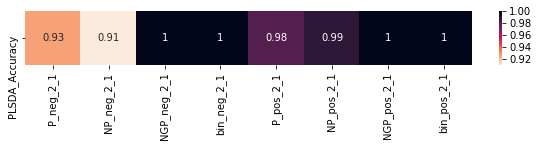

In [174]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

In [175]:
Score = {}
Score['P_neg_2_1'] = np.mean(PLS_score['P_neg'])
Score['NP_neg_2_1'] = np.mean(PLS_score['NP_neg'])
Score['NGP_neg_2_1'] = np.mean(PLS_score['NGP_neg'])
Score['bin_neg_2_1'] = np.mean(PLS_score['bin_neg'])
Score['P_pos_2_1'] = np.mean(PLS_score['P_pos'])
Score['NP_pos_2_1'] = np.mean(PLS_score['NP_pos'])
Score['NGP_pos_2_1'] = np.mean(PLS_score['NGP_pos'])
Score['bin_pos_2_1'] = np.mean(PLS_score['bin_pos'])

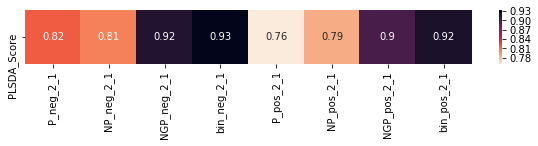

In [176]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [177]:
Accuracy_std = {}
Accuracy_std['P_neg_2_1'] = np.std(PLS_accu['P_neg'])
Accuracy_std['NP_neg_2_1'] = np.std(PLS_accu['NP_neg'])
Accuracy_std['NGP_neg_2_1'] = np.std(PLS_accu['NGP_neg'])
Accuracy_std['bin_neg_2_1'] = np.std(PLS_accu['bin_neg'])
Accuracy_std['P_pos_2_1'] = np.std(PLS_accu['P_pos'])
Accuracy_std['NP_pos_2_1'] = np.std(PLS_accu['NP_pos'])
Accuracy_std['NGP_pos_2_1'] = np.std(PLS_accu['NGP_pos'])
Accuracy_std['bin_pos_2_1'] = np.std(PLS_accu['bin_pos'])

In [178]:
Score_std = {}
Score_std['P_neg_2_1'] = np.std(PLS_score['P_neg'])
Score_std['NP_neg_2_1'] = np.std(PLS_score['NP_neg'])
Score_std['NGP_neg_2_1'] = np.std(PLS_score['NGP_neg'])
Score_std['bin_neg_2_1'] = np.std(PLS_score['bin_neg'])
Score_std['P_pos_2_1'] = np.std(PLS_score['P_pos'])
Score_std['NP_pos_2_1'] = np.std(PLS_score['NP_pos'])
Score_std['NGP_pos_2_1'] = np.std(PLS_score['NGP_pos'])
Score_std['bin_pos_2_1'] = np.std(PLS_score['bin_pos'])

In [179]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
P_neg_2_1,0.926667,0.013333
NP_neg_2_1,0.909333,0.034667
NGP_neg_2_1,1.000000,0.000000
bin_neg_2_1,1.000000,0.000000
P_pos_2_1,0.980000,0.016330
NP_pos_2_1,0.989333,0.015549
NGP_pos_2_1,1.000000,0.000000
bin_pos_2_1,1.000000,0.000000


In [180]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

,Score,SD
P_neg_2_1,0.819679,0.006164
NP_neg_2_1,0.806261,0.009605
NGP_neg_2_1,0.918434,0.002457
bin_neg_2_1,0.934370,0.001118
P_pos_2_1,0.760486,0.021820
NP_pos_2_1,0.788825,0.010361
NGP_pos_2_1,0.900896,0.002868
bin_pos_2_1,0.922044,0.001458


### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [181]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []
for j in PLS_Feat:
    if j.endswith('neg'):
        Spectra = aligned_all_neg
    elif j.endswith('pos'):
        Spectra = aligned_all_pos
    index.append(j)
    ratio = []
    nsamples = []
    n_groups = []
    number = round(0.02*len(Spectra))
    total_m = 0
    for i in range(len(PLS_Feat[j])):
        total_m = total_m + PLS_Feat[j][i][1]
    magni.append(PLS_Feat[j][0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.data.loc[PLS_Feat[j][i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [182]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:]])

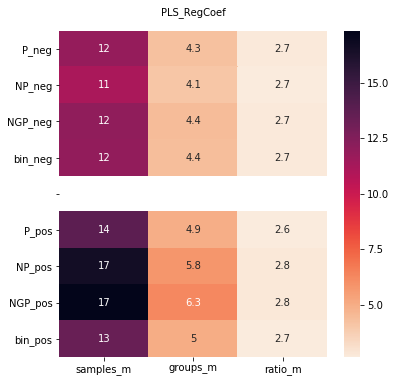

In [183]:
f, ax = plt.subplots(figsize=(6, 6))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'PLS_RegCoef',horizontalalignment='center', verticalalignment='center')
plt.show()

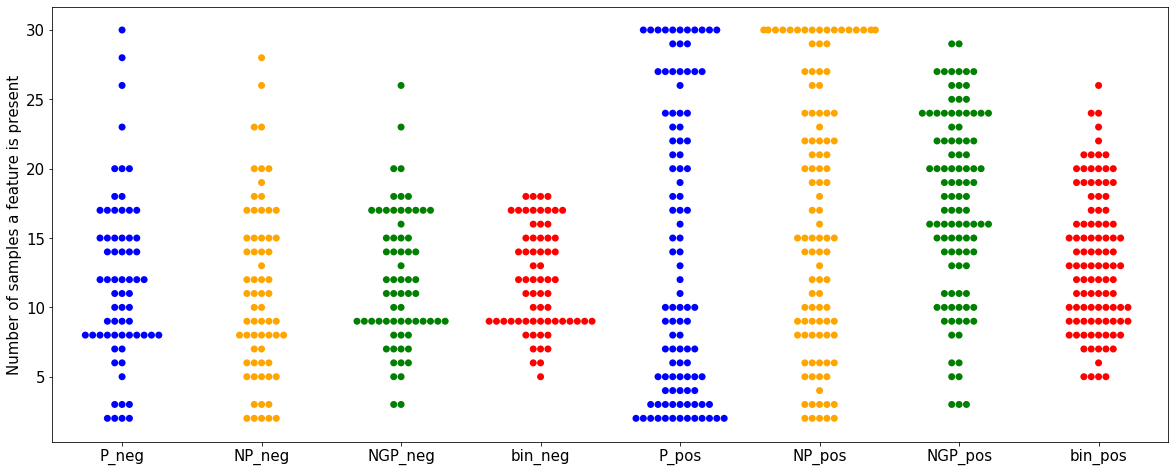

In [184]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]

sns.swarmplot(data=data, size = 7, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_Feat.keys())[i] for i in range(len(PLS_Feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [185]:
print('Magnitude of most important features for each case:')
print(magni)

Magnitude of most important features for each case:
[18.38475698802759, 15.822874498628128, 4.720508833193964, 4.08619625146353, 25.461583041216766, 12.381239227152218, 8.732031152555583, 5.640010479712642]


### Model with the full dataset and sample representation on the two most important Components/Latent Variables

NGP data treatment for the negative mode

In [186]:
from sklearn.cross_decomposition import PLSRegression

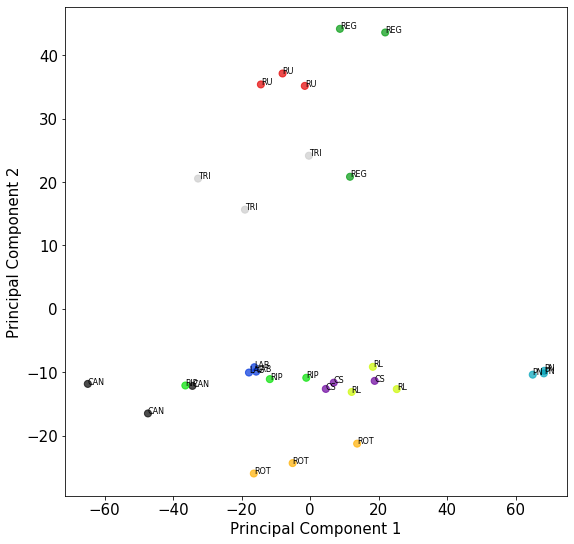

In [187]:
plsda = PLSRegression(n_components = 15)
#Fitting the model and getting the X_scores
plsda.fit(X=Euc_NGP_neg.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 10)
col_lbl = colours(range(10))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.unique_labels()[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

Binary processed data for the negative mode

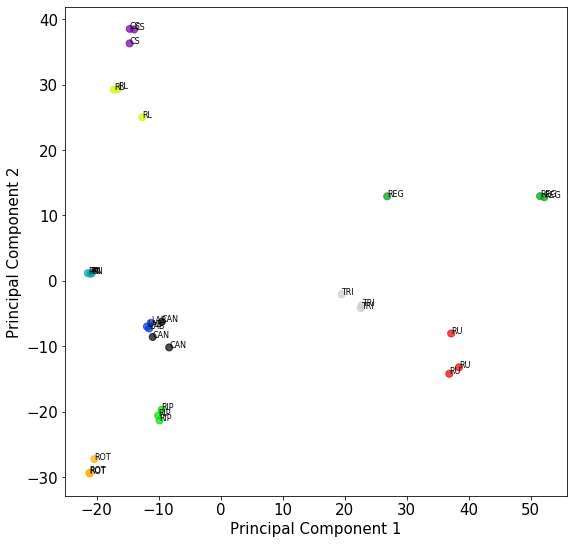

In [188]:
plsda = PLSRegression(n_components = 15)
#Fitting the model and getting the X_scores
plsda.fit(X=binary_neg1.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 10)
col_lbl = colours(range(10))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

#Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.unique_labels()[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

## Alignment 3-3

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function optim_PLS in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [189]:
%%capture
#PLS applied in the negative dataset.
P_neg_PLS_3_3 = ma.optim_PLS(Euc_P_neg2, matrix, max_comp = 50)
NP_neg_PLS_3_3 = ma.optim_PLS(Euc_NP_neg2, matrix, max_comp = 50)
NGP_neg_PLS_3_3 = ma.optim_PLS(Euc_NGP_neg2, matrix, max_comp = 50)
bin_neg_PLS_3_3 = ma.optim_PLS(binary_neg2, matrix, max_comp = 50)

#PLS applied in the positive dataset.
P_pos_PLS_3_3 = ma.optim_PLS(Euc_P_pos2, matrix, max_comp = 50)
NP_pos_PLS_3_3 = ma.optim_PLS(Euc_NP_pos2, matrix, max_comp = 50)
NGP_pos_PLS_3_3 = ma.optim_PLS(Euc_NGP_pos2, matrix, max_comp = 50)
bin_pos_PLS_3_3 = ma.optim_PLS(binary_pos2, matrix, max_comp = 50)

Performance based on number of components - Alignment: 3-3, Negative Mode


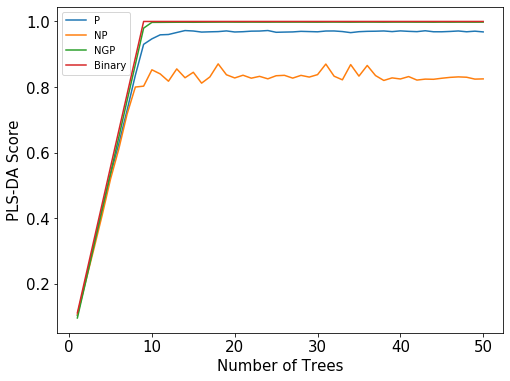

In [190]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_neg_PLS_3_3[0])
plt.plot(range(1,51),NP_neg_PLS_3_3[0])
plt.plot(range(1,51),NGP_neg_PLS_3_3[0])
plt.plot(range(1,51),bin_neg_PLS_3_3[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 3-3, Negative Mode')

Performance based on number of components - Alignment: 3-3, Positive Mode


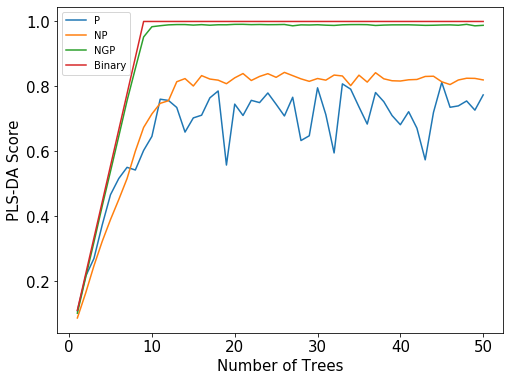

In [191]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_pos_PLS_3_3[0])
plt.plot(range(1,51),NP_pos_PLS_3_3[0])
plt.plot(range(1,51),NGP_pos_PLS_3_3[0])
plt.plot(range(1,51),bin_pos_PLS_3_3[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 3-3, Positive Mode')

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better when it reached around 15. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [192]:
PLS_accu = {}
PLS_score = {}
PLS_Feat = {}

In [193]:
%%capture
P_neg_PLS = ma.model_PLSDA(Euc_P_neg2, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['P_neg'] = P_neg_PLS[0]
PLS_score['P_neg'] = P_neg_PLS[1]
PLS_Feat['P_neg'] = P_neg_PLS[3]

NP_neg_PLS = ma.model_PLSDA(Euc_NP_neg2, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['NP_neg'] = NP_neg_PLS[0]
PLS_score['NP_neg'] = NP_neg_PLS[1]
PLS_Feat['NP_neg'] = NP_neg_PLS[3]

NGP_neg_PLS = ma.model_PLSDA(Euc_NGP_neg2, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['NGP_neg'] = NGP_neg_PLS[0]
PLS_score['NGP_neg'] = NGP_neg_PLS[1]
PLS_Feat['NGP_neg'] = NGP_neg_PLS[3]

bin_neg_PLS = ma.model_PLSDA(binary_neg2, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['bin_neg'] = bin_neg_PLS[0]
PLS_score['bin_neg'] = bin_neg_PLS[1]
PLS_Feat['bin_neg'] = bin_neg_PLS[3]

In [194]:
%%capture
P_pos_PLS = ma.model_PLSDA(Euc_P_pos2, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['P_pos'] = P_pos_PLS[0]
PLS_score['P_pos'] = P_pos_PLS[1]
PLS_Feat['P_pos'] = P_pos_PLS[3]

NP_pos_PLS = ma.model_PLSDA(Euc_NP_pos2, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['NP_pos'] = NP_pos_PLS[0]
PLS_score['NP_pos'] = NP_pos_PLS[1]
PLS_Feat['NP_pos'] = NP_pos_PLS[3]

NGP_pos_PLS = ma.model_PLSDA(Euc_NGP_pos2, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['NGP_pos'] = NGP_pos_PLS[0]
PLS_score['NGP_pos'] = NGP_pos_PLS[1]
PLS_Feat['NGP_pos'] = NGP_pos_PLS[3]

bin_pos_PLS = ma.model_PLSDA(binary_pos2, matrix, n_comp = 15, iter_num = 25, feat_type = 'Coef')
PLS_accu['bin_pos'] = bin_pos_PLS[0]
PLS_score['bin_pos'] = bin_pos_PLS[1]
PLS_Feat['bin_pos'] = bin_pos_PLS[3]

Accuracy based on the dataset - Alignment: 3-3, Negative and Positive Mode


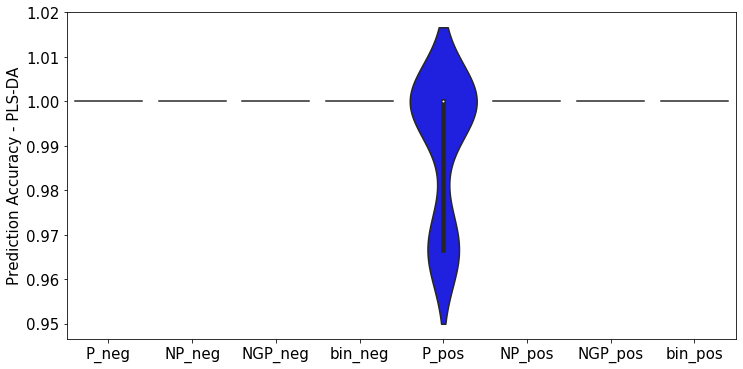

In [195]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['blue','orange','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Accuracy based on the dataset - Alignment: 3-3, Negative and Positive Mode')

Performance score based on the dataset - Alignment: 3-3, Negative and Positive Mode


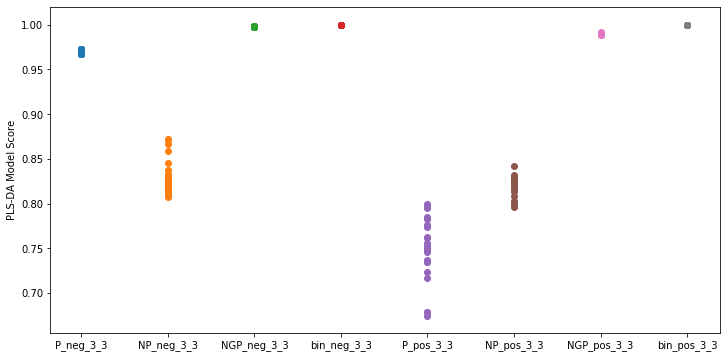

In [196]:
f, ax = plt.subplots(figsize=(12,6))
plt.scatter(['P_neg_3_3']*len(PLS_score['P_neg']), PLS_score['P_neg'])
plt.scatter(['NP_neg_3_3']*len(PLS_score['NP_neg']), PLS_score['NP_neg'])
plt.scatter(['NGP_neg_3_3']*len(PLS_score['NGP_neg']), PLS_score['NGP_neg'])
plt.scatter(['bin_neg_3_3']*len(PLS_score['bin_neg']), PLS_score['bin_neg'])
plt.scatter(['P_pos_3_3']*len(PLS_score['P_pos']), PLS_score['P_pos'])
plt.scatter(['NP_pos_3_3']*len(PLS_score['NP_pos']), PLS_score['NP_pos'])
plt.scatter(['NGP_pos_3_3']*len(PLS_score['NGP_pos']), PLS_score['NGP_pos'])
plt.scatter(['bin_pos_3_3']*len(PLS_score['bin_pos']), PLS_score['bin_pos'])
plt.ylabel('PLS-DA Model Score')
print('Performance score based on the dataset - Alignment: 3-3, Negative and Positive Mode')

In [197]:
Accuracy = {}
Accuracy['P_neg_3_3'] = np.mean(PLS_accu['P_neg'])
Accuracy['NP_neg_3_3'] = np.mean(PLS_accu['NP_neg'])
Accuracy['NGP_neg_3_3'] = np.mean(PLS_accu['NGP_neg'])
Accuracy['bin_neg_3_3'] = np.mean(PLS_accu['bin_neg'])
Accuracy['P_pos_3_3'] = np.mean(PLS_accu['P_pos'])
Accuracy['NP_pos_3_3'] = np.mean(PLS_accu['NP_pos'])
Accuracy['NGP_pos_3_3'] = np.mean(PLS_accu['NGP_pos'])
Accuracy['bin_pos_3_3'] = np.mean(PLS_accu['bin_pos'])

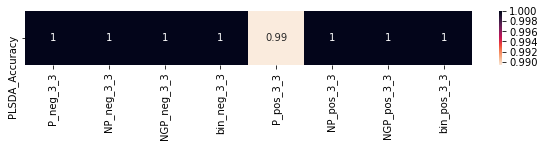

In [198]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

In [199]:
Score = {}
Score['P_neg_3_3'] = np.mean(PLS_score['P_neg'])
Score['NP_neg_3_3'] = np.mean(PLS_score['NP_neg'])
Score['NGP_neg_3_3'] = np.mean(PLS_score['NGP_neg'])
Score['bin_neg_3_3'] = np.mean(PLS_score['bin_neg'])
Score['P_pos_3_3'] = np.mean(PLS_score['P_pos'])
Score['NP_pos_3_3'] = np.mean(PLS_score['NP_pos'])
Score['NGP_pos_3_3'] = np.mean(PLS_score['NGP_pos'])
Score['bin_pos_3_3'] = np.mean(PLS_score['bin_pos'])

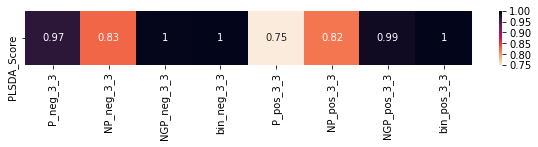

In [200]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [201]:
Accuracy_std = {}
Accuracy_std['P_neg_3_3'] = np.std(PLS_accu['P_neg'])
Accuracy_std['NP_neg_3_3'] = np.std(PLS_accu['NP_neg'])
Accuracy_std['NGP_neg_3_3'] = np.std(PLS_accu['NGP_neg'])
Accuracy_std['bin_neg_3_3'] = np.std(PLS_accu['bin_neg'])
Accuracy_std['P_pos_3_3'] = np.std(PLS_accu['P_pos'])
Accuracy_std['NP_pos_3_3'] = np.std(PLS_accu['NP_pos'])
Accuracy_std['NGP_pos_3_3'] = np.std(PLS_accu['NGP_pos'])
Accuracy_std['bin_pos_3_3'] = np.std(PLS_accu['bin_pos'])

In [202]:
Score_std = {}
Score_std['P_neg_3_3'] = np.std(PLS_score['P_neg'])
Score_std['NP_neg_3_3'] = np.std(PLS_score['NP_neg'])
Score_std['NGP_neg_3_3'] = np.std(PLS_score['NGP_neg'])
Score_std['bin_neg_3_3'] = np.std(PLS_score['bin_neg'])
Score_std['P_pos_3_3'] = np.std(PLS_score['P_pos'])
Score_std['NP_pos_3_3'] = np.std(PLS_score['NP_pos'])
Score_std['NGP_pos_3_3'] = np.std(PLS_score['NGP_pos'])
Score_std['bin_pos_3_3'] = np.std(PLS_score['bin_pos'])

In [203]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
P_neg_3_3,1.000000,0.000000
NP_neg_3_3,1.000000,0.000000
NGP_neg_3_3,1.000000,0.000000
bin_neg_3_3,1.000000,0.000000
P_pos_3_3,0.989333,0.015549
NP_pos_3_3,1.000000,0.000000
NGP_pos_3_3,1.000000,0.000000
bin_pos_3_3,1.000000,0.000000


In [204]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

,Score,SD
P_neg_3_3,0.969947,0.001910
NP_neg_3_3,0.829804,0.018625
NGP_neg_3_3,0.997738,0.000138
bin_neg_3_3,1.000000,0.000000
P_pos_3_3,0.748941,0.034512
NP_pos_3_3,0.820695,0.010409
NGP_pos_3_3,0.989739,0.000718
bin_pos_3_3,1.000000,0.000000


### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [205]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []
for j in PLS_Feat:#['neg2-1_direct']:
    if j.endswith('neg'):
        Spectra = aligned_all_neg2
    elif j.endswith('pos'):
        Spectra = aligned_all_pos2
    index.append(j)
    ratio = []
    nsamples = []
    n_groups = []
    number = round(0.02*len(Spectra))
    total_m = 0
    for i in range(len(PLS_Feat[j])):
        total_m = total_m + PLS_Feat[j][i][1]
    magni.append(PLS_Feat[j][0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.data.loc[PLS_Feat[j][i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [206]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:]])

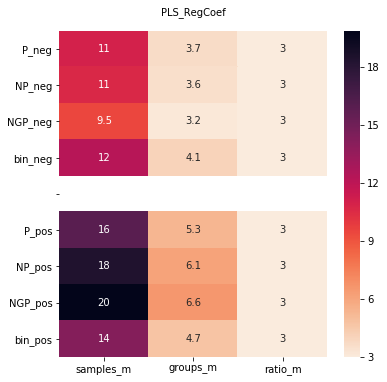

In [207]:
f, ax = plt.subplots(figsize=(6, 6))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'PLS_RegCoef',horizontalalignment='center', verticalalignment='center')
plt.show()

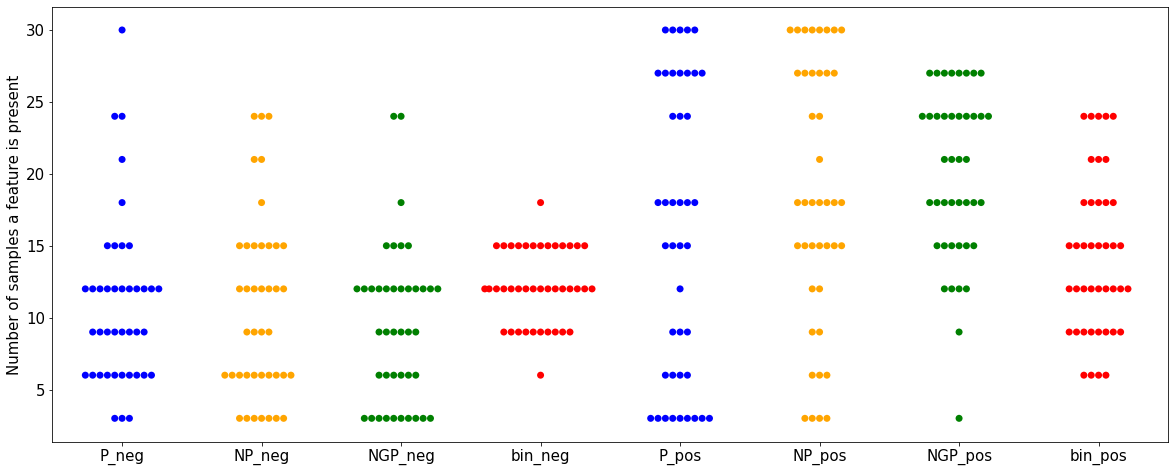

In [208]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]

sns.swarmplot(data=data, size = 7, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_Feat.keys())[i] for i in range(len(PLS_Feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [209]:
print('Magnitude of most important features for each case:')
print(magni)

Magnitude of most important features for each case:
[14.41166554468424, 22.614840163535426, 4.873615412891025, 3.2764436699095563, 15.164372938274935, 7.684140157755762, 5.618281182551353, 5.099205161096982]


### Model with the full dataset and sample representation on the two most important Components/Latent Variables

NGP data treatment for the negative mode

In [210]:
from sklearn.cross_decomposition import PLSRegression

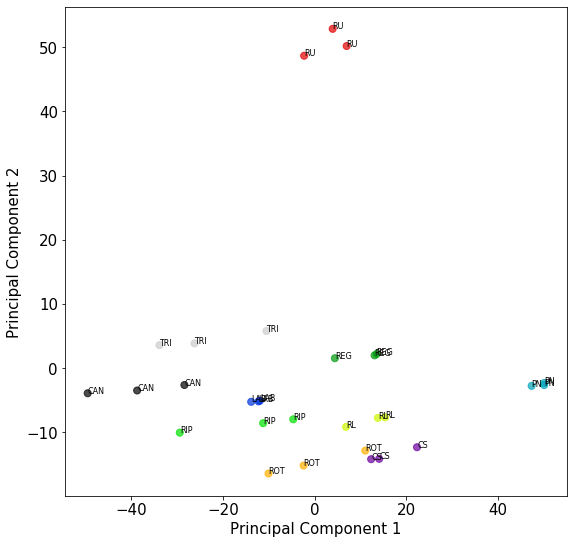

In [211]:
plsda = PLSRegression(n_components = 15)
#Fitting the model and getting the X_scores
plsda.fit(X=Euc_NGP_neg2.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 10)
col_lbl = colours(range(10))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.unique_labels()[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

Binary processed data for the negative mode

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:292: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)


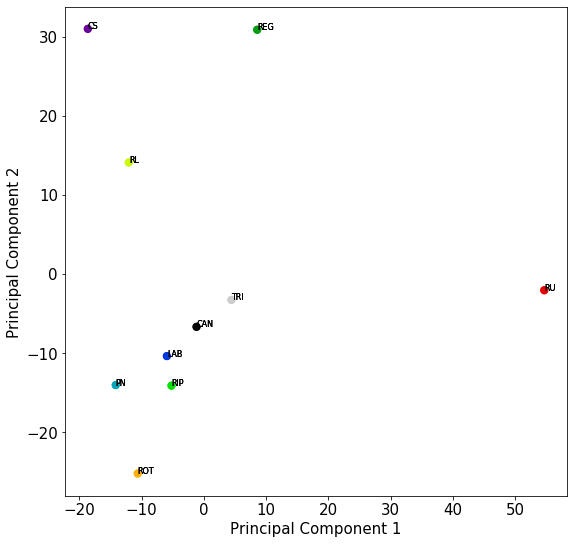

In [212]:
plsda = PLSRegression(n_components = 15)
#Fitting the model and getting the X_scores
plsda.fit(X=binary_neg2.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 10)
col_lbl = colours(range(10))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

#Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.unique_labels()[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [213]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [214]:
permuta = ma.permutation_PLSDA(Euc_P_neg, n_comp = 15, iter_num = 150)
CV_PLS['P_neg'] = permuta[0]
PMs_PLS['P_neg'] = permuta[1]
pvalue_PLS['P_neg'] = permuta[2]

permuta = ma.permutation_PLSDA(Euc_NP_neg, n_comp = 15, iter_num = 150)
CV_PLS['NP_neg'] = permuta[0]
PMs_PLS['NP_neg'] = permuta[1]
pvalue_PLS['NP_neg'] = permuta[2]

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


In [215]:
permuta = ma.permutation_PLSDA(Euc_NGP_neg, n_comp = 15, iter_num = 150)
CV_PLS['NGP_neg'] = permuta[0]
PMs_PLS['NGP_neg'] = permuta[1]
pvalue_PLS['NGP_neg'] = permuta[2]

permuta = ma.permutation_PLSDA(binary_neg1, n_comp = 15, iter_num = 150)
CV_PLS['bin_neg'] = permuta[0]
PMs_PLS['bin_neg'] = permuta[1]
pvalue_PLS['bin_neg'] = permuta[2]

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


In [216]:
permuta = ma.permutation_PLSDA(Euc_P_pos, n_comp = 15, iter_num = 150)
CV_PLS['P_pos'] = permuta[0]
PMs_PLS['P_pos'] = permuta[1]
pvalue_PLS['P_pos'] = permuta[2]

permuta = ma.permutation_PLSDA(Euc_NP_pos, n_comp = 15, iter_num = 150)
CV_PLS['NP_pos'] = permuta[0]
PMs_PLS['NP_pos'] = permuta[1]
pvalue_PLS['NP_pos'] = permuta[2]

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


In [217]:
permuta = ma.permutation_PLSDA(Euc_NGP_pos, n_comp = 15, iter_num = 150)
CV_PLS['NGP_pos'] = permuta[0]
PMs_PLS['NGP_pos'] = permuta[1]
pvalue_PLS['NGP_pos'] = permuta[2]

permuta = ma.permutation_PLSDA(binary_pos1, n_comp = 15, iter_num = 150)
CV_PLS['bin_pos'] = permuta[0]
PMs_PLS['bin_pos'] = permuta[1]
pvalue_PLS['bin_pos'] = permuta[2]

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


In [218]:
permuta = ma.permutation_PLSDA(Euc_P_neg2, n_comp = 15, iter_num = 150)
CV_PLS['P_neg2'] = permuta[0]
PMs_PLS['P_neg2'] = permuta[1]
pvalue_PLS['P_neg2'] = permuta[2]

permuta = ma.permutation_PLSDA(Euc_NP_neg2, n_comp = 15, iter_num = 150)
CV_PLS['NP_neg2'] = permuta[0]
PMs_PLS['NP_neg2'] = permuta[1]
pvalue_PLS['NP_neg2'] = permuta[2]

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


In [219]:
permuta = ma.permutation_PLSDA(Euc_NGP_neg2, n_comp = 15, iter_num = 150)
CV_PLS['NGP_neg2'] = permuta[0]
PMs_PLS['NGP_neg2'] = permuta[1]
pvalue_PLS['NGP_neg2'] = permuta[2]

permuta = ma.permutation_PLSDA(binary_neg2, n_comp = 7, iter_num = 150)
CV_PLS['bin_neg2'] = permuta[0]
PMs_PLS['bin_neg2'] = permuta[1]
pvalue_PLS['bin_neg2'] = permuta[2]

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:322: UserWarning: X scores are null at iteration 6
  warnings.warn('X scores are null at iteration %s' % k)


In [220]:
permuta = ma.permutation_PLSDA(binary_neg2, n_comp = 7, iter_num = 150)
CV_PLS['bin_neg2'] = permuta[0]
PMs_PLS['bin_neg2'] = permuta[1]
pvalue_PLS['bin_neg2'] = permuta[2]

In [221]:
permuta = ma.permutation_PLSDA(Euc_P_pos2, n_comp = 15, iter_num = 150)
CV_PLS['P_pos2'] = permuta[0]
PMs_PLS['P_pos2'] = permuta[1]
pvalue_PLS['P_pos2'] = permuta[2]

permuta = ma.permutation_PLSDA(Euc_NP_pos2, n_comp = 15, iter_num = 150)
CV_PLS['NP_pos2'] = permuta[0]
PMs_PLS['NP_pos2'] = permuta[1]
pvalue_PLS['NP_pos2'] = permuta[2]

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


In [222]:
permuta = ma.permutation_PLSDA(Euc_NGP_pos2, n_comp = 15, iter_num = 150)
CV_PLS['NGP_pos2'] = permuta[0]
PMs_PLS['NGP_pos2'] = permuta[1]
pvalue_PLS['NGP_pos2'] = permuta[2]

permuta = ma.permutation_PLSDA(binary_pos2, n_comp = 7, iter_num = 150)
CV_PLS['bin_pos2'] = permuta[0]
PMs_PLS['bin_pos2'] = permuta[1]
pvalue_PLS['bin_pos2'] = permuta[2]

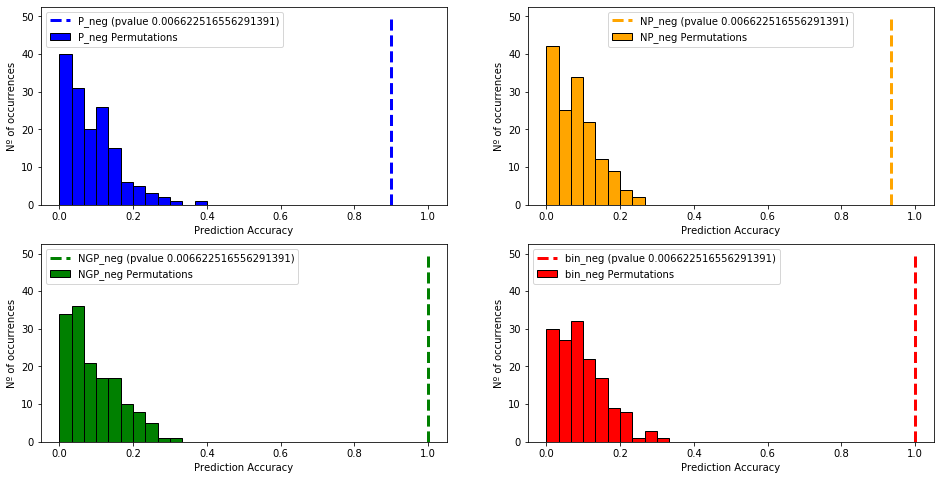

In [223]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'bin_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

for i in range(len(Names)):
    quadrant[i].hist(PMs_PLS[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV_PLS[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue_PLS[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

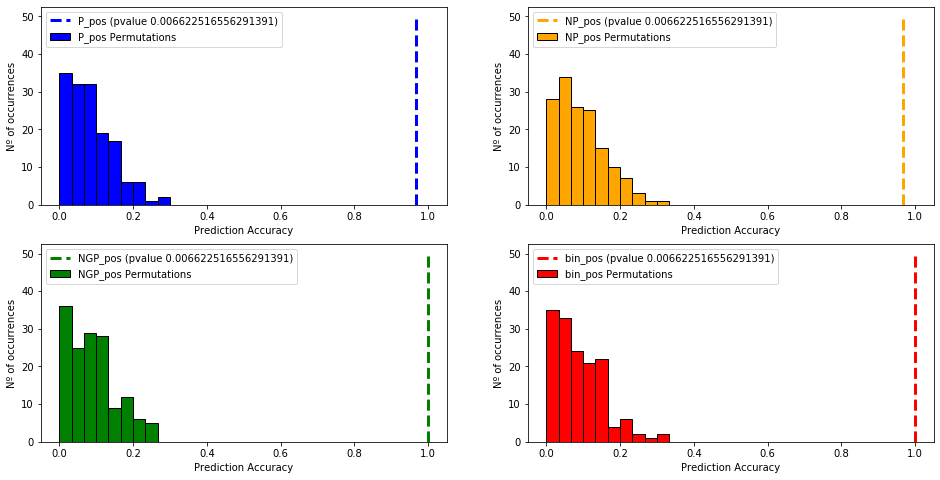

In [224]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'bin_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
for i in range(len(Names)):
    quadrant[i].hist(PMs_PLS[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV_PLS[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue_PLS[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

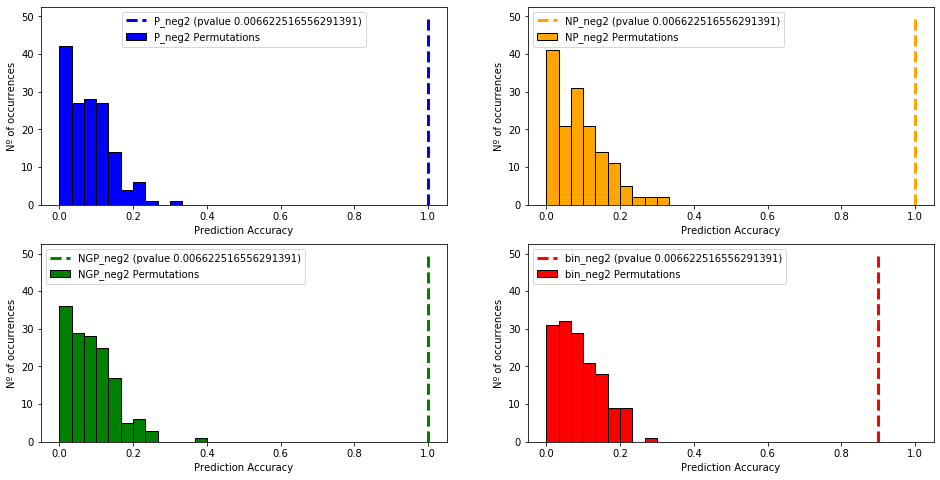

In [225]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
for i in range(len(Names)):
    quadrant[i].hist(PMs_PLS[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV_PLS[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue_PLS[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

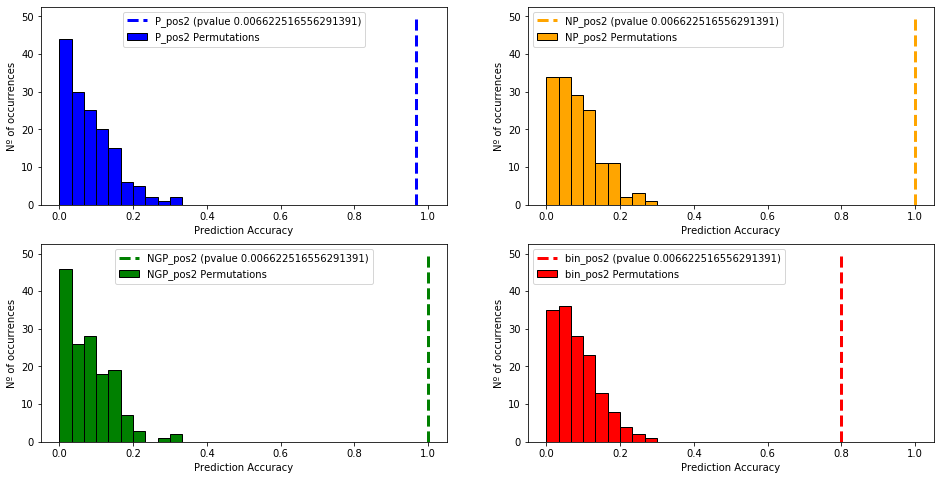

In [226]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
for i in range(len(Names)):
    quadrant[i].hist(PMs_PLS[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV_PLS[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue_PLS[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()